# Datenanalyse der konkreten Fragen der Stakeholders

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import functions as fn
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.graph_objects as go
from scipy.stats import chi2_contingency, chisquare, pearsonr


In [2]:
df_user_raw = pd.read_parquet('data/user_filtered.parquet')
df_clickstreams_raw = pd.read_parquet('data/clickstreams_filtered.parquet')

In [3]:
df_user = df_user_raw.copy()

df_clickstreams = df_clickstreams_raw.copy()

df_geo = pd.read_csv('data/new_geo_info_.csv')

df_stat = pd.read_csv('data/new_statistics_.csv')

In [4]:
df_user.head()

user_id account_created_date first_active_timestamp first_booking_date  \
0  gxn3p5htnn           2010-06-28    2009-03-19 04:32:55                NaT   
1  820tgsjxq7           2011-05-25    2009-05-23 17:48:09                NaT   
2  bjjt8pjhuk           2011-12-05    2009-10-31 06:01:29         2012-09-08   
3  osr2jwljor           2010-01-01    2010-01-01 21:56:19         2010-01-02   
4  lsw9q7uk0j           2010-01-02    2010-01-02 01:25:58         2010-01-05   

  user_gender  user_age signup_platform  signup_process user_language  \
0   -unknown-       NaN       affiliate               0            en   
1      female      38.0       affiliate               0            en   
2        male      42.0       affiliate               0            en   
3   -unknown-       NaN             web               0            en   
4        male      46.0             web               0            en   

  marketing_channel marketing_provider first_tracked_affiliate  \
0            direct             direct               untracked   
1               seo             google               untracked   
2            direct             direct               untracked   
3             other              other                     omg   
4             other         craigslist               untracked   

  signup_application first_device first_web_browser destination_country  \
0                Web  Mac Desktop            Chrome                 NDF   
1                Web  Mac Desktop            Chrome                 NDF   
2                Web  Mac Desktop           Firefox               other   
3                Web  Mac Desktop            Chrome                  US   
4                Web  Mac Desktop            Safari                  US   

  first_active_date  
0        2009-03-19  
1        2009-05-23  
2        2009-10-31  
3        2010-01-01  
4        2010-01-02

In [5]:
df_clickstreams.head()

session_user_id  session_action session_action_type session_action_detail  \
0      d1mm9tcy42          lookup                None                  None   
1      d1mm9tcy42  search_results               click   view_search_results   
2      d1mm9tcy42          lookup                None                  None   
3      d1mm9tcy42  search_results               click   view_search_results   
4      d1mm9tcy42          lookup                None                  None   

  session_device_type  time_passed_in_seconds  is_new_session  
0     Windows Desktop                   319.0           False  
1     Windows Desktop                 67753.0            True  
2     Windows Desktop                   301.0           False  
3     Windows Desktop                 22141.0            True  
4     Windows Desktop                   435.0           False

In [6]:
df_geo.head()

country   latitude   longitude  distance_in_km  area_in_km2  \
0      AU -26.853388  133.275160      15297.7440    7741220.0   
1      CA  62.393303  -96.818146       2828.1333    9984670.0   
2      DE  51.165707   10.452764       7879.5680     357022.0   
3      ES  39.896027   -2.487694       7730.7240     505370.0   
4      FR  46.232193    2.209667       7682.9450     643801.0   

  country_language  language_similarity  
0              eng                 0.00  
1              eng                 0.00  
2              deu                72.61  
3              spa                92.25  
4              fra                92.06

In [7]:
df_stat.head()

age_group country population_gender  population_thousands
0      100+      AU            female                   1.0
1     95-99      AU            female                   9.0
2     90-94      AU            female                  47.0
3     85-89      AU            female                 118.0
4     80-84      AU            female                 199.0

## 1. Welche Zusammenhänge gibt es zwischen der Sprache des Users und der Sprache des besuchten Landes?

**Ziel:** Prüfen, ob Nutzer eher Länder mit gleicher/ähnlicher Sprache besuchen.

**Vorgehen:**
1. Sprache des Ziellandes aus `geo_info` anreichern (ISO-639).
2. Fehlende Werte und Sonderfälle (`NDF`, `other`) explizit behandeln.
3. Kontingenztabelle (User-Sprache x Landessprache) erstellen (absolut + zeilen-normalisiert).
4. Zusammenhang quantifizieren: Chi-Quadrat *plus* Effektstärke (Cramer’s V).
5. Visualisierung:  2 Heatmaps


### 1.1. Sprache des Ziellandes anreichern

`geo_info` liefert pro Land (country als ISO-3166-alpha2) eine `country_language` im ISO-639-3 Format (z.B. eng, deu, spa, fra).

Da `user_language` in den Userdaten als ISO-639-1 (z.B. en, de, fr) kodiert ist, müssen wir country_language von alpha3 --> alpha2 konvertieren, bevor wir eine sinnvolle Kontingenztabelle `user_language` x `Landessprache` berechnen können.

In [8]:
df_geo[['country', 'country_language']].head()

country country_language
0      AU              eng
1      CA              eng
2      DE              deu
3      ES              spa
4      FR              fra

In [9]:
lang_alpha2={
    'eng' : 'en',
    'deu' : 'de', 
    'spa' : 'es',
    'fra' : 'fr', 
    'ita' : 'it',
    'nld' : 'nl',
    'por' : 'pt'
}
df_geo['lang_country_alpha2'] = df_geo.country_language.replace(lang_alpha2) # Zu alpha2 codes konvertieren

Wir mergen df_user mit geo_info über destination_country --> country, um jedem User die Landessprache des Ziellandes (lang_country_alpha2) zuzuordnen.

In [10]:
# Verknüpfung der Nutzer-Daten mit den Geo-Daten basierend auf dem Zielland
user_geo = df_user.merge(df_geo[['country', 'lang_country_alpha2']], how='left', left_on='destination_country', right_on='country')
user_geo.head()

user_id account_created_date first_active_timestamp first_booking_date  \
0  gxn3p5htnn           2010-06-28    2009-03-19 04:32:55                NaT   
1  820tgsjxq7           2011-05-25    2009-05-23 17:48:09                NaT   
2  bjjt8pjhuk           2011-12-05    2009-10-31 06:01:29         2012-09-08   
3  osr2jwljor           2010-01-01    2010-01-01 21:56:19         2010-01-02   
4  lsw9q7uk0j           2010-01-02    2010-01-02 01:25:58         2010-01-05   

  user_gender  user_age signup_platform  signup_process user_language  \
0   -unknown-       NaN       affiliate               0            en   
1      female      38.0       affiliate               0            en   
2        male      42.0       affiliate               0            en   
3   -unknown-       NaN             web               0            en   
4        male      46.0             web               0            en   

  marketing_channel marketing_provider first_tracked_affiliate  \
0            direct             direct               untracked   
1               seo             google               untracked   
2            direct             direct               untracked   
3             other              other                     omg   
4             other         craigslist               untracked   

  signup_application first_device first_web_browser destination_country  \
0                Web  Mac Desktop            Chrome                 NDF   
1                Web  Mac Desktop            Chrome                 NDF   
2                Web  Mac Desktop           Firefox               other   
3                Web  Mac Desktop            Chrome                  US   
4                Web  Mac Desktop            Safari                  US   

  first_active_date country lang_country_alpha2  
0        2009-03-19     NaN                 NaN  
1        2009-05-23     NaN                 NaN  
2        2009-10-31     NaN                 NaN  
3        2010-01-01      US                  en  
4        2010-01-02      US                  en

### 1.2. Fehlende Werte und Sonderfälle explizit behandeln.

NaN in `lang_country_alpha2` = 133153 und `destination_country` in {'NDF','other'} = 133153

Das Auftreten fehlender Werte ist hier vollständig durch Sonderfälle ohne definierbare Landessprache erklärbar (keine Buchung bzw. Zielland außerhalb der Liste). Damit ist der Merge konsistent, und wir können in den nächsten Schritten NDF/other gezielt ausschließen, ohne Gefahr, valide Buchungen zu verlieren.

Genau diese Fälle müssen wir für Frage 1 konsequent entfernen, weil es sonst kein „visited country language“ gibt.

In [11]:
print('Anzahl an NaN-Werten in Sprache des Landes nach dem Merge: ', user_geo[['lang_country_alpha2']].isnull().sum())
print('Nutzer, die "NDF" oder "other" haben: ' ,user_geo[user_geo.destination_country.isin(['NDF', 'other'])]['user_id'].count())

Anzahl an NaN-Werten in Sprache des Landes nach dem Merge:  lang_country_alpha2    133153
dtype: int64
Nutzer, die "NDF" oder "other" haben:  133153


In [12]:
user_geo = user_geo[~user_geo.destination_country.isin(['NDF','other'])]

### 1.3. Kontingenztabelle erstellen

Die Analyse wird stark von Englisch geprägt sein.

In [13]:
user_geo.groupby(['user_language']).agg(
    no_users=('user_id', 'count')
    ).sort_values(by='no_users', ascending=False)

no_users
user_language          
en                75638
zh                  439
fr                  375
de                  252
es                  228
ko                  180
it                   97
ru                   95
ja                   72
pt                   44
sv                   37
nl                   29
da                   17
tr                   16
no                   12
pl                   11
cs                    7
fi                    6
el                    5
th                    3
hu                    2
ca                    2
is                    1

In [14]:
user_geo.groupby(['lang_country_alpha2']).agg(
    no_users=('user_id', 'count')
    ).sort_values(by='no_users', ascending=False)

no_users
lang_country_alpha2          
en                      65600
fr                       4960
it                       2783
es                       2218
de                       1042
nl                        750
pt                        215

Diese Tabelle zeigt die Rohanzahlen für jede Kombination `user_language` x `Landessprache`. Sie ist die Basis für Chi-Quadrat.
Auffällig ist, dass sehr große Counts bei `en` --> `en` zu erwarten sind, da sowohl Nutzersprache als auch Ziellandsprachen stark von Englisch dominiert sind. Für eine Interpretation „welche Ziele bevorzugt eine Sprachgruppe“ sind Rohcounts allein jedoch ungeeignet wegen ungleicher Gruppengrößen.

In [15]:
contingency_table_abs = pd.crosstab(user_geo['user_language'], user_geo['lang_country_alpha2'])
contingency_table_abs

lang_country_alpha2   de     en    es    fr    it   nl   pt
user_language                                              
ca                     0      2     0     0     0    0    0
cs                     0      6     1     0     0    0    0
da                     0     14     2     0     1    0    0
de                    24    202     7    10     6    2    1
el                     0      2     2     1     0    0    0
en                   997  64016  2152  4821  2712  732  208
es                     6    172    20    18     9    1    2
fi                     0      5     0     1     0    0    0
fr                     8    272    11    67    11    4    2
hu                     0      2     0     0     0    0    0
is                     0      1     0     0     0    0    0
it                     2     65     6     3    19    2    0
ja                     0     65     1     4     2    0    0
ko                     0    156     2    12     8    2    0
nl                     2     19     0     3     1    4    0
no                     0     12     0     0     0    0    0
pl                     0      6     2     1     1    0    1
pt                     0     41     1     0     0    1    1
ru                     1     76     6     5     7    0    0
sv                     0     33     2     0     0    2    0
th                     0      3     0     0     0    0    0
tr                     0     14     0     1     1    0    0
zh                     2    416     3    13     5    0    0

Diese Darstellung ist deutlich besser als Rohcounts, weil sie die extreme Dominanz von `en` als Nutzersprache kontrolliert. 

In den Heatmaps sollten wir die Werte als Prozent formatieren und idealerweise nur Top-K Nutzersprachen zeigen, damit das Muster sofort erkennbar ist.

In [16]:
# relative Häufigkeiten
contingency_table_norm = pd.crosstab(user_geo['user_language'], user_geo['lang_country_alpha2'], normalize='index')
contingency_table_norm

lang_country_alpha2        de        en        es        fr        it  \
user_language                                                           
ca                   0.000000  1.000000  0.000000  0.000000  0.000000   
cs                   0.000000  0.857143  0.142857  0.000000  0.000000   
da                   0.000000  0.823529  0.117647  0.000000  0.058824   
de                   0.095238  0.801587  0.027778  0.039683  0.023810   
el                   0.000000  0.400000  0.400000  0.200000  0.000000   
en                   0.013181  0.846347  0.028451  0.063738  0.035855   
es                   0.026316  0.754386  0.087719  0.078947  0.039474   
fi                   0.000000  0.833333  0.000000  0.166667  0.000000   
fr                   0.021333  0.725333  0.029333  0.178667  0.029333   
hu                   0.000000  1.000000  0.000000  0.000000  0.000000   
is                   0.000000  1.000000  0.000000  0.000000  0.000000   
it                   0.020619  0.670103  0.061856  0.030928  0.195876   
ja                   0.000000  0.902778  0.013889  0.055556  0.027778   
ko                   0.000000  0.866667  0.011111  0.066667  0.044444   
nl                   0.068966  0.655172  0.000000  0.103448  0.034483   
no                   0.000000  1.000000  0.000000  0.000000  0.000000   
pl                   0.000000  0.545455  0.181818  0.090909  0.090909   
pt                   0.000000  0.931818  0.022727  0.000000  0.000000   
ru                   0.010526  0.800000  0.063158  0.052632  0.073684   
sv                   0.000000  0.891892  0.054054  0.000000  0.000000   
th                   0.000000  1.000000  0.000000  0.000000  0.000000   
tr                   0.000000  0.875000  0.000000  0.062500  0.062500   
zh                   0.004556  0.947608  0.006834  0.029613  0.011390   

lang_country_alpha2        nl        pt  
user_language                            
ca                   0.000000  0.000000  
cs                   0.000000  0.000000  
da                   0.000000  0.000000  
de                   0.007937  0.003968  
el                   0.000000  0.000000  
en                   0.009678  0.002750  
es                   0.004386  0.008772  
fi                   0.000000  0.000000  
fr                   0.010667  0.005333  
hu                   0.000000  0.000000  
is                   0.000000  0.000000  
it                   0.020619  0.000000  
ja                   0.000000  0.000000  
ko                   0.011111  0.000000  
nl                   0.137931  0.000000  
no                   0.000000  0.000000  
pl                   0.000000  0.090909  
pt                   0.022727  0.022727  
ru                   0.000000  0.000000  
sv                   0.054054  0.000000  
th                   0.000000  0.000000  
tr                   0.000000  0.000000  
zh                   0.000000  0.000000

### 1.4.Signifikanztest und Effektgröße

Auf Basis der absoluten Kontingenztabelle testen wir mit dem Chi-Quadrat-Test, ob user_language und Landessprache des Ziellandes unabhängig sind. Zusätzlich berechnen wir Cramer's V als Effektstärke, weil bei großen Stichproben p-Werte oft extrem klein werden, auch wenn der praktische Effekt gering ist.

**Ergebnis:**

Der Test ist hochsignifikant (p ≈ 0), d.h. statistisch ist ein Zusammenhang nachweisbar. Gleichzeitig ist die Effektstärke mit Cramer's V = 0,0303 sehr klein (praktisch schwacher Zusammenhang).

**Validitäts-Hinweis:**

 Der Anteil der Zellen mit erwarteten Häufigkeiten < 5 liegt bei ~0,733 (73,3%). Das ist für den klassischen Chi-Quadrat-Test problematisch und zeigt, dass die Tabelle viele seltene Kombinationen hat.
Konsequenz: Der p-Wert ist hier nur eingeschränkt interpretierbar. Die Effektstärke (V) ist in diesem Setting der verlässlichere Indikator.

**Der p-Wert ist hier nur eingeschränkt interpretierbar, für eine robuste Interpretation sollten auch Residuen betrachtet werden.**


**P.S.**

Der Wert von **Cramers V liegt** immer zwischen 0 und 1 und misst die Stärke des Zusammenhangs zwischen zwei nominalskalierten (kategorialen) Variablen:
-  0 bedeutet keinen Zusammenhang
-  1 bedeutet einen perfekten Zusammenhang

Er ist eine normierte Effektstärke für den Chi-Quadrat-Test und erlaubt Vergleiche der Zusammenhangsstärke über verschiedene Tabellengrößen hinweg. 

In [17]:
# Kontingenztabelle + Chi2-Test + Validitäts-Check (expected < 5)

chi2, p, dof, expected = chi2_contingency(contingency_table_abs)

expected_lt5_share = (expected < 5).sum() / expected.size # Anteil der erwarteten Häufigkeiten < 5
print('Chi2-Wert=%.6f' % (chi2))
print('dof=%.6f' % (dof))
print('p-value=%.55f' % (p))
print('Share of expected counts < 5:', round(expected_lt5_share, 4))

# Effektstärke: Cramer’s V 
def cramers_v(confusion: pd.DataFrame) -> float:
    """Berechnet Cramers V für eine Kontingenztabelle."""
    chi2_, _, _, _ = chi2_contingency(confusion, correction=False) # _ bedeutet, dass wir die anderen Rückgabewerte ignorieren
    n = confusion.to_numpy().sum() # Gesamtanzahl der Beobachtungen
    r, k = confusion.shape # Anzahl der Zeilen und Spalten
    phi2 = chi2_ / n

    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1)) # Korrektur für Bias
    rcorr = r - ((r-1)**2) / (n-1) # Korrigierte Anzahl der Zeilen
    kcorr = k - ((k-1)**2) / (n-1) # Korrigierte Anzahl der Spalten
    return float(np.sqrt(phi2corr / max(1e-12, min(kcorr-1, rcorr-1)))) # Cramers V

v = cramers_v(contingency_table_abs)
print("Cramér's V:", round(v, 4))

Chi2-Wert=558.670006
dof=132.000000
p-value=0.0000000000000000000000000000000000000000000000000000076
Share of expected counts < 5: 0.7329
Cramér's V: 0.0303


Nachdem Chi-Quadrat nur zeigt, dass ein Zusammenhang existiert, berechnen wir standardisierte Residuen, um zu sehen, welche Sprachpaare den Zusammenhang treiben.

Das Residuum misst die Abweichung zwischen beobachteter und erwarteter Häufigkeit (unter Unabhängigkeit), skaliert durch die erwartete Streuung.
- Positives Residuum: Kombination kommt häufiger vor als erwartet („überrepräsentiert“).
- Negatives Residuum: Kombination kommt seltener vor als erwartet („unterrepräsentiert“).

**Interpretation:**
 - Top positive residuals (häufiger als erwartet)
    - de --> de (11.20): sehr starke Überrepräsentation: Deutschsprachige Nutzer buchen deutschsprachige Zielländer deutlich häufiger, als es bei Unabhängigkeit zu erwarten wäre.
    - fr --> fr (8.79) und it --> it (8.32) sowie es --> es (5.28): identisches Muster, ebenfalls klarer Hinweis auf sprachnahe Ziele.
    - nl --> nl (7.02): ebenfalls stark, obwohl die Gesamtzahl NL klein ist.
    - Weitere positive Paare wie el --> es, pl --> pt/es, sv --> nl: diese sind interpretierbar, aber hier ist Vorsicht nötig, weil einige dieser Nutzer-Sprachgruppen klein sind und dadurch einzelne Zellen stärker schwanken können.
- Top negative residuals (seltener als erwartet)
    - zh --> fr/it/es/nl/de (≈ −2 bis −2.8): chinesischsprachige Nutzer buchen diese nicht-englischen Sprachräume seltener als erwartet (relativ zu ihrer Gesamtverteilung und den Spaltenmargen).
    - fr --> en (−2.53): französischsprachige Nutzer buchen englischsprachige Zielländer seltener als erwartet.
    - it --> en (−1.88) ist schwächer (unter −2 ist es eher ein Hinweis als ein “starker” Befund).

**Die Residuen zeigen klar, dass der statistische Zusammenhang nicht „überall ein bisschen“ entsteht, sondern vor allem durch diagonale Sprachpaare (de-->de, fr-->fr, it-->it, es-->es, nl-->nl).**

In [18]:
# Wo genau ist der Zusammenhang? --> Standardisierte Residuen 
obs = contingency_table_abs.to_numpy()
resid = (obs - expected) / np.sqrt(expected)
resid_df = pd.DataFrame(resid, index=contingency_table_abs.index, columns=contingency_table_abs.columns) # DataFrame der standardisierten Residuen

# Top-Paare (überrepräsentiert) / (unterrepräsentiert)
top_pos = resid_df.stack().sort_values(ascending=False).head(10)
top_neg = resid_df.stack().sort_values(ascending=True).head(10)

print('Top positive residuals (stärker als erwartet):')
print(top_pos)
print('Top negative residuals (seltener als erwartet):')
print(top_neg)

Top positive residuals (stärker als erwartet):
user_language  lang_country_alpha2
de             de                     11.204335
fr             fr                      8.785485
it             it                      8.319273
nl             nl                      7.024380
pl             pt                      5.552369
es             es                      5.279580
el             es                      4.911274
pl             es                      3.005270
sv             nl                      2.745674
nl             de                      2.580185
dtype: float64
Top negative residuals (seltener als erwartet):
user_language  lang_country_alpha2
zh             fr                    -2.844598
               it                    -2.708833
               es                    -2.696266
fr             en                    -2.534812
zh             nl                    -2.060258
it             en                    -1.880684
pt             fr                    -1.677358
zh         

### 1.5. Visualisierung

Die Heatmap soll die dominanten Muster zeigen und auf einen Blick lesbar bleiben, ohne durch sehr kleine Gruppen verzerrt zu werden.

Deswegen wählen wir die Top-10 häufigste Sprachen und Länder zur Visualisierung. 

In [19]:
# Nur die wichtigsten Sprachen/Länder anzeigen (Top 10), sonst wird es unübersichtlich
top_langs = user_geo['user_language'].value_counts().nlargest(10).index
top_countries = user_geo['lang_country_alpha2'].value_counts().nlargest(10).index

crosstab_filtered_with_en = contingency_table_norm.loc[top_langs, top_countries]

In fast allen Nutzersprachen ist der Anteil englischsprachiger Ziele sehr hoch (z.B. en-Nutzer: 84,6% en-Zielländer; zh-Nutzer: 94,8% en-Zielländer). Das ist ein starkes Zeichen dafür, dass englischsprachige Ziele (insb. USA) die Buchungen dominieren und dadurch viele feinere Muster überdecken.

**Folgerung für die Analyse:**

 Diese Darstellung ist korrekt, aber durch die Dominanz von en als Ziellandssprache schwer zu differenzieren. Um nicht-englische Präferenzen sichtbar zu machen (z.B. de-->de, fr-->fr, es-->es), ist es sinnvoll, eine zweite Visualisierung ohne en-Zielländer zu betrachten.

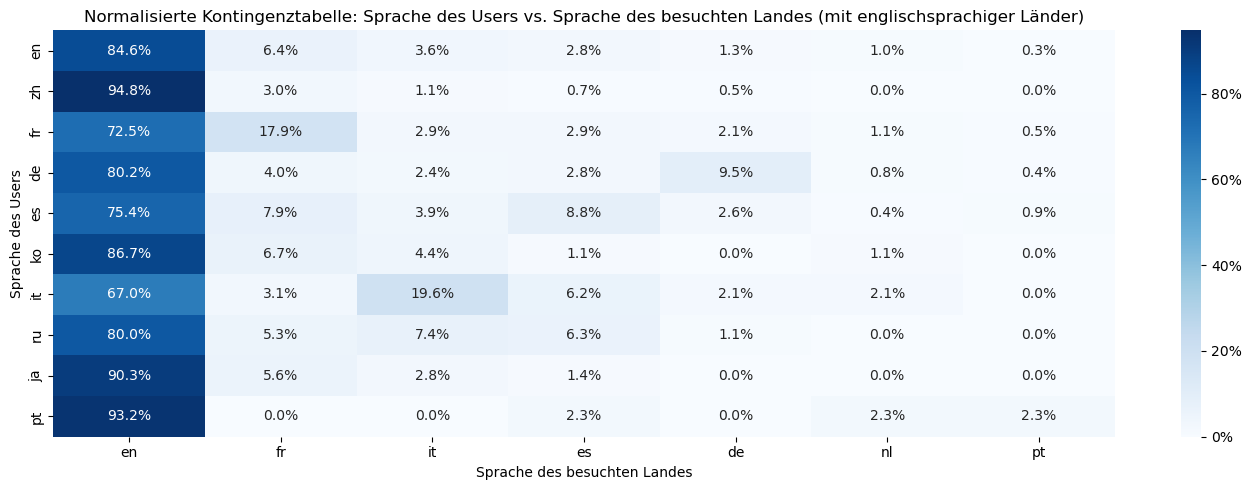

In [20]:
# Heatmap der normalisierten Kontingenztabelle (mit englischsprachiger Länder)
plt.figure(figsize=(14, 5))
ax = sns.heatmap(crosstab_filtered_with_en, annot=True, cmap='Blues', fmt='.1%',cbar=True)
cbar = ax.collections[0].colorbar
cbar.formatter = mtick.PercentFormatter(xmax=1.0)  # weil Daten 0..1
cbar.update_ticks()
plt.title('Normalisierte Kontingenztabelle: Sprache des Users vs. Sprache des besuchten Landes (mit englischsprachiger Länder)')
plt.xlabel('Sprache des besuchten Landes')
plt.ylabel('Sprache des Users')
plt.tight_layout()
plt.show()

**Beobachtete Muster**:
- de-Nutzer buchen unter den nicht-englischen Zielen besonders häufig deutschsprachige Länder (ca. 48% in der de-Spalte).
- fr-Nutzer zeigen eine starke Konzentration auf französischsprachige Ziele (ca. 65,0% es).
- it-Nutzer konzentrieren sich stark auf italienischsprachige Ziele (ca. 59,4% it).
- nl-Nutzer zeigen eine deutlich erhöhte Quote für niederländischsprachige Ziele (ca. 40% nl).

Diese Diagonal-Struktur spricht für sprachnahe Reisepräferenzen, die in der „mit USA“-Heatmap weniger sichtbar waren.

**Nach dem Entfernen von en werden die Stichproben pro Zelle kleiner. Einige Prozentwerte können dadurch instabil sein (insb. bei seltenen Nutzersprachen). Deshalb sollte man für Schlussfolgerungen v.a. auf die großen Gruppen (Top-Sprachen) fokussieren und zusätzlich absolute Counts bzw. Mindest-n pro Zeile prüfen.**

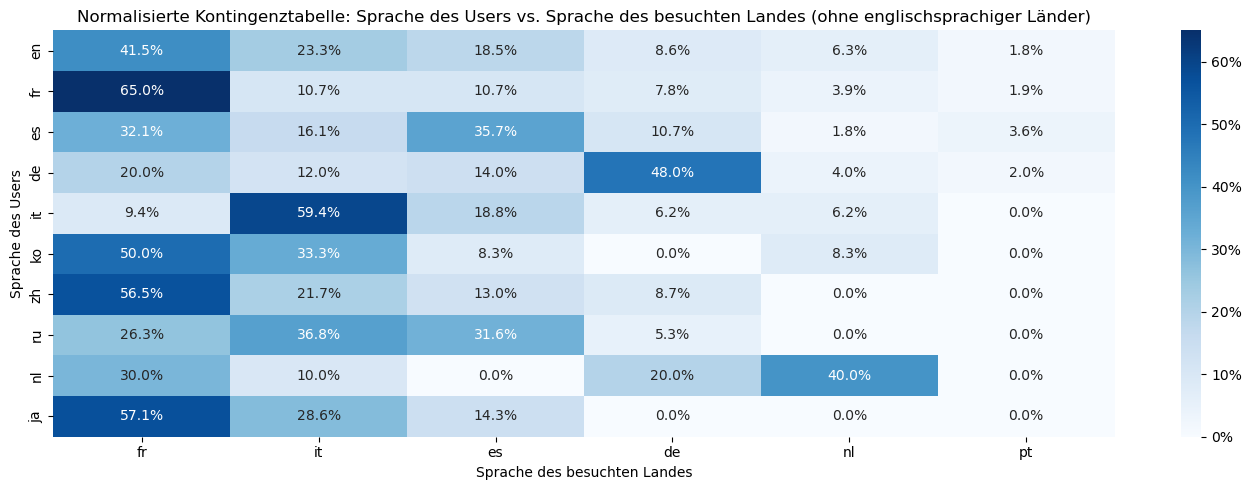

lang_country_alpha2   de    es    fr    it   nl   pt
user_language                                       
cs                     0     1     0     0    0    0
da                     0     2     0     1    0    0
de                    24     7    10     6    2    1
el                     0     2     1     0    0    0
en                   997  2152  4821  2712  732  208
es                     6    20    18     9    1    2
fi                     0     0     1     0    0    0
fr                     8    11    67    11    4    2
it                     2     6     3    19    2    0
ja                     0     1     4     2    0    0
ko                     0     2    12     8    2    0
nl                     2     0     3     1    4    0
pl                     0     2     1     1    0    1
pt                     0     1     0     0    1    1
ru                     1     6     5     7    0    0
sv                     0     2     0     0    2    0
tr                     0     0     1     1    0    0
zh                     2     3    13     5    0    0

In [21]:
# Heatmap der normalisierten Kontingenztabelle (ohne englischsprachiger Länder)
user_geo_no_en = user_geo[user_geo['lang_country_alpha2'] != 'en'] # englischsprachige Länder entfernen

crosstab_filtered_without_usa = pd.crosstab(user_geo_no_en['user_language'], user_geo_no_en['lang_country_alpha2'], normalize='index')

top_langs = user_geo_no_en['user_language'].value_counts().nlargest(10).index
top_countries = user_geo_no_en['lang_country_alpha2'].value_counts().nlargest(10).index

crosstab_filtered_no_usa = crosstab_filtered_without_usa.loc[top_langs, top_countries]

plt.figure(figsize=(14, 5))
ax = sns.heatmap(crosstab_filtered_no_usa, annot=True, cmap='Blues', fmt='.1%')
cbar = ax.collections[0].colorbar
cbar.formatter = mtick.PercentFormatter(xmax=1.0)  # weil Daten 0..1
cbar.update_ticks()
plt.title('Normalisierte Kontingenztabelle: Sprache des Users vs. Sprache des besuchten Landes (ohne englischsprachiger Länder)')
plt.xlabel('Sprache des besuchten Landes')
plt.ylabel('Sprache des Users')
plt.tight_layout()
plt.show()

# später löschen
pd.crosstab(user_geo_no_en['user_language'], user_geo_no_en['lang_country_alpha2'])

### Fazit zu Frage 1:

**Es gibt einen Zusammenhang zwischen Nutzersprache und Landessprache des Ziellandes**: Der Chi-Quadrat-Test ist hochsignifikant. Gleichzeitig ist die praktische Effekttärke sehr gering (Cramer’s V ≈ 0,03), d.h. die Nutzersprache erklärt nur einen kleinen Teil der Varianz im Zielland.

**Der Zusammenhang wird vor allem durch wenige, aber klare Muster getragen**: Die standardisierte Residuen zeigen eine starke Überrepräsentation sprachgleicher Paare (insb. de-->de, fr-->fr, it-->it). Englischsprachige Zielländer dominieren die Buchungen; ohne englischsprachige Ziele werden diese sprachnahe Präferenzen deutlich sichtbarer. Aufgrund vieler kleiner erwarteter Zellhäufigkeiten sollten p-Werte vorsichtig interpretiert und der Fokus auf Effektstärken und robuste Top-K-Muster gelegt werden.

## 2. Gibt es Zusammenhänge zwischen dem Alter des Users und der Altersstruktur des besuchten Landes?

**Ziel:** Prüfen, ob die Altersverteilung der Buchenden (je Zielland) von der Altersstruktur des Ziellandes abweicht.

**Vorgehen:**
1. Allgemeine Prüfung (Durschnittsalter-Vergleich).
2. Alterskategorien harmonisieren (Users und Statistikdaten in gleiche Bins).
3. Missingness-Check: Fehlende Altersangaben nach Gender und Zielland.
4. Für jedes Zielland: Vergleich *User-Altersverteilung* vs *Bevölkerungs-Altersverteilung*.
5. Über-/Unterrepräsentation je Alterskategorie in Prozentpunkten visualisieren (Top-Länder nach n).

### 2.1. Durchschnittsalter-Vergleich

Zunächst vergleichen wir das Durchschnittsalter der User mit dem Durchschnittsalter der Bevölkerung im jeweiligen Zielland. Dies gibt einen ersten Hinweis darauf, ob es generelle Korrelation gibt.

In [22]:
# Altersgrenzen extrahieren
age_split = pd.DataFrame(df_stat['age_group'].str.split('-').tolist()) # Altersspannen aufteilen und in DataFrame speichern
low = pd.to_numeric(age_split[0].str.replace('+', ''), errors='coerce') # untere Altersgrenze (100+ wird zu 100)
high = pd.to_numeric(age_split[1], errors='coerce').fillna(low) # obere Altersgrenze (für 100+ wird obere Grenze auf untere gesetzt)
print(low)
print(high)

0      100
1       95
2       90
3       85
4       80
      ... 
415     95
416     90
417     15
418     85
419     80
Name: 0, Length: 420, dtype: int64
0      100.0
1       99.0
2       94.0
3       89.0
4       84.0
       ...  
415     99.0
416     94.0
417     19.0
418     89.0
419     84.0
Name: 1, Length: 420, dtype: float64


In [23]:
# Klassenmitte berechnen
df_stat['age_midpoint'] = (low + high) / 2

# Gewichtete Werte berechnen
df_stat['weighted_age'] = df_stat['age_midpoint'] * df_stat['population_thousands']

# Gewichteter Durchschnitt pro Land
country_avg_age = df_stat.groupby('country')['weighted_age'].sum() / df_stat.groupby('country')['population_thousands'].sum()

country_avg_age

country
AU    38.084312
CA    40.076273
DE    44.213985
ES    41.827045
FR    40.529477
GB    40.163581
IT    43.845433
NL    40.923077
PT    42.457442
US    38.132346
dtype: float64

In [24]:
user_avg_age = df_user.groupby('destination_country')['user_age'].mean()
user_avg_age

destination_country
AU       37.131148
CA       36.948718
DE       36.531250
ES       34.959403
FR       37.271233
GB       38.035179
IT       36.884577
NDF      36.929431
NL       35.927119
PT       35.788462
US       35.905633
other    36.201297
Name: user_age, dtype: float64

In [25]:
fig = px.scatter(
    x=country_avg_age.values, 
    y=user_avg_age[country_avg_age.index].values,
    text=country_avg_age.index,
    trendline="ols",
    trendline_color_override="tomato",
    color_discrete_sequence=['steelblue'],
    labels={'x': 'Durchschnittsalter der Bevölkerung', 'y': 'Durchschnittsalter der Nutzer'}
)

# Textposition und gestrichelte Linie konfigurieren
fig.update_traces(textposition='top center')
fig.update_traces(line=dict(dash='dash'), selector=dict(mode='lines'))
fig.show()

In [26]:
x = country_avg_age.values
y = user_avg_age[country_avg_age.index].values

# Pearson-Korrelation und p-Wert berechnen
corr, p_value = pearsonr(x, y)

print(f"Pearson-Korrelationskoeffizient: {corr:.4f}")
print(f"p-Wert: {p_value:.10f}")

if p_value < 0.05:
    print("Der Zusammenhang ist statistisch signifikant (p < 0.05).")
else:
    print("Der Zusammenhang ist nicht statistisch signifikant (p >= 0.05).")

Pearson-Korrelationskoeffizient: -0.1933
p-Wert: 0.5926897315
Der Zusammenhang ist nicht statistisch signifikant (p >= 0.05).


**Ergebnis:** Die Korrelation zwischen Benutzer-Durchschnittsalter und Bevölkerungs-Durchschnittsalter ist eher gering (-0,19). Dabei muss man auch beachten, dass der Benutzer-Durchschnittsalter von der Altersverteilung der USA beeinflusst wird.

### 2.2. Alterskategorien harmonisieren

Die Bevölkerungsstatistik liegt in Altersgruppen wie "15-19" oder "19-24" vor. Um sie mit den Userdaten zu vergleichen, extrahieren wir die untere Altersgrenze (age_min).

In [27]:
df_stat['age_min'] = low # untere Altersgrenze als neue Spalte
stat = df_stat[df_stat['age_min'] >= 15].copy()

Wir definieren ein gemeinsames Altersraster. Dadurch werden die Bevölkerungsdaten und die Userdaten direkt vergleichbar.

In [28]:
bins = [15, 25, 35, 45, 55, 65, np.inf]

labels = ['15-24', '25-34', '35-44','45-54','55-64','65+']

In `df_stat` mappen wir jede Statistik-Altersgruppe über `age_min` in die neuen Kategorien 

`right=False` bedeutet, dass Intervall links-geschlossen undrechts-offen ist. Das verhindert Grenzfehler beim Zuordnen.

In [29]:
df_stat['age_category_new'] = pd.cut(
    stat['age_min'],
    bins=bins,
    labels=labels,
    right=False
)

In `df_user` erzeugen wir dieselben Kategorien aus dem numerischen `user_age`.

Beide Quellen haben nun dieselben Alterskategorien, wodurch ein Vergleich pro Land möglich wird.

In [30]:
df_user['user_age_category'] = pd.cut(
    df_user['user_age'],
    bins=bins,
    labels=labels,
    right=False
)

Dieser Merge ist nur dann sinnvoll, wenn `user_gender` und `population_gender` kompatibel kodiert sind (male/female).

Darum prüfen wir Missingness in den nächsten Schritten.

In [31]:
bins_user = [15, 25, 35, 45, 55, 65, np.inf]
labels_user = ['15-24', '25-34', '35-44','45-54','55-64','65+']

df_user['user_age_category'] = pd.cut(df_user['user_age'], bins=bins_user, labels=labels_user, right=False)

In [32]:
# Merge der Nutzer-Daten mit den Statistik-Daten basierend auf Zielland, Alterskategorie und Geschlecht
df_user_stat= pd.merge(
    df_user, 
    df_stat[['country', 'population_thousands', 'age_category_new', 'population_gender']], 
    left_on=['destination_country', 'user_age_category', 'user_gender'], 
    right_on=['country', 'age_category_new', 'population_gender'], 
    how='inner')

In [33]:
df_user_stat.head()

user_id account_created_date first_active_timestamp first_booking_date  \
0  lsw9q7uk0j           2010-01-02    2010-01-02 01:25:58         2010-01-05   
1  lsw9q7uk0j           2010-01-02    2010-01-02 01:25:58         2010-01-05   
2  0d01nltbrs           2010-01-03    2010-01-03 19:19:05         2010-01-13   
3  0d01nltbrs           2010-01-03    2010-01-03 19:19:05         2010-01-13   
4  a1vcnhxeij           2010-01-04    2010-01-04 00:42:11         2010-07-29   

  user_gender  user_age signup_platform  signup_process user_language  \
0        male      46.0             web               0            en   
1        male      46.0             web               0            en   
2        male      47.0             web               0            en   
3        male      47.0             web               0            en   
4        male      50.0             web               0            en   

  marketing_channel  ... signup_application first_device first_web_browser  \
0             other  ...                Web  Mac Desktop            Safari   
1             other  ...                Web  Mac Desktop            Safari   
2            direct  ...                Web  Mac Desktop            Safari   
3            direct  ...                Web  Mac Desktop            Safari   
4             other  ...                Web  Mac Desktop            Safari   

  destination_country first_active_date user_age_category country  \
0                  US        2010-01-02             45-54      US   
1                  US        2010-01-02             45-54      US   
2                  US        2010-01-03             45-54      US   
3                  US        2010-01-03             45-54      US   
4                  US        2010-01-04             45-54      US   

  population_thousands age_category_new  population_gender  
0              11413.0            45-54               male  
1              10659.0            45-54               male  
2              11413.0            45-54               male  
3              10659.0            45-54               male  
4              11413.0            45-54               male  

[5 rows x 22 columns]

### 2.2. Missingness-Check

Nutzer mit `user_gender = '-unknown-'` haben extrem häufig fehlendes Alter (~83%). Bei male (~8,6%) und female (~7,0%) ist Missingness deutlich niedriger.

Wenn wir ohne weitere Maßnahmen Altersanalysen durchführen, könnten "unknown"-Gender Nutzer die Ergebnisse verzerren.

D.h.: Für robuste Ergebnisse sollten wir 'unknown'- Werte explizit ausschließen.

In [34]:
df_user['age_missing'] = df_user['user_age'].isna().astype(int) # 1 wenn Alter fehlt, sonst 0

df_user.groupby('user_gender')[['age_missing']].mean().sort_values('age_missing', ascending=False) # Durchschnittlicher Anteil fehlender Altersangaben pro Geschlecht

age_missing
user_gender             
-unknown-       0.830383
other           0.194245
male            0.086065
female          0.070188

Der Missingness-Check nach `destination_country` zeigt, dass NDF den höchsten Missing-Anteil hat (~55%). Das ist plausibel, weil NDF "keine Buchung" bedeutet und diese Nutzer oft weniger vollständig profiliert sind.

Für Frage 2 sollte `NDF` sowie `other` ausgeschlossen werden, sonst wird das Altersprofil stark verzerrt.

In [35]:
df_user.groupby('destination_country')[['age_missing']].mean().sort_values('age_missing', ascending=False) # Durchschnittlicher Anteil fehlender Altersangaben pro Zielland

age_missing
destination_country             
NDF                     0.548668
IT                      0.287100
PT                      0.274419
FR                      0.264113
other                   0.253831
CA                      0.250000
ES                      0.244815
GB                      0.240806
US                      0.224333
NL                      0.213333
DE                      0.201536
AU                      0.194340

### 2.3. Vergleich *User-Altersverteilung* vs *Bevölkerungs-Altersverteilung*

`pop_dist` aggregiert die Bevölkerungszahlen pro Land und Alterskategorie. 

Das ist unsere "Soll-Verteilung": Wenn Buchende demografisch wie die Gesamtbevölkerung wären, sollte die User-Altersverteilung pro Land ähnlich aussehen.

In [36]:
# Verteilung der Bevölkerung pro Land und Alterskategorie
pop_dist = df_stat.groupby(['country', 'age_category_new'], observed=True)['population_thousands'].sum().reset_index(name='population_thousands')
pop_dist.head()

country age_category_new  population_thousands
0      AU            15-24                3112.0
1      AU            25-34                3492.0
2      AU            35-44                3256.0
3      AU            45-54                3147.0
4      AU            55-64                2749.0

In [37]:
# Verteilung der Nutzer pro Zielland und Alterskategorie
user_dist = df_user.groupby(['destination_country', 'user_age_category'], observed=True).size().reset_index(name='user_count')
user_dist.head()

destination_country user_age_category  user_count
0                  AU             15-24          25
1                  AU             25-34         187
2                  AU             35-44         124
3                  AU             45-54          54
4                  AU             55-64          26

Die Berechnung von `user_share` normiert die Anzahl der Nutzer in jeder Alterskategorie pro Land auf 100%.

`population_share` normiert die Bevölkerungszahlen pro Land auf 100%. Damit vergleichen wir Formen von Verteilungen.

In [38]:
user_dist['user_share'] = (
    user_dist
    .groupby('destination_country')['user_count']
    .transform(lambda x: x / x.sum())
) # Anteil der Nutzer pro Alterskategorie im jeweiligen Zielland

pop_dist['population_share'] = (
    pop_dist
    .groupby('country')['population_thousands']
    .transform(lambda x: x / x.sum())
) # Anteil der Bevölkerung pro Alterskategorie im jeweiligen Land

Durch Merge entsteht pro Land und Alterskategorie eine Zeile mit Bevölkerungsanteil und Useranteil.

Anschließend werden fehlende user_count/user_share (Altersgruppen, die in den Userdaten nicht vorkommen) mit 0 aufgefüllt.

In [39]:
# Zusammenführung der Verteilungen für Vergleich
comparison = pop_dist.merge(
    user_dist,
    right_on=['destination_country', 'user_age_category'],
    left_on=['country', 'age_category_new'],
    how='left'
)

comparison.head()

country age_category_new  population_thousands  population_share  \
0      AU            15-24                3112.0          0.160918   
1      AU            25-34                3492.0          0.180568   
2      AU            35-44                3256.0          0.168364   
3      AU            45-54                3147.0          0.162728   
4      AU            55-64                2749.0          0.142148   

  destination_country user_age_category  user_count  user_share  
0                  AU             15-24          25    0.058548  
1                  AU             25-34         187    0.437939  
2                  AU             35-44         124    0.290398  
3                  AU             45-54          54    0.126464  
4                  AU             55-64          26    0.060890

In [40]:
comparison['user_count'] = comparison['user_count'].fillna(0).astype(int)
comparison['user_share'] = comparison['user_share'].fillna(0)

### 2.4.Signifikanztest und Effektgröße

Hier prüfen wir nicht die Beziehung zwischen zwei Variablen, sondern ob die beobachtete Verteilung (Altersverteilung der Buchenden in einem Land) zu der vorgegebenen Referenzverteilung passt (Altersstruktur der Gesamtbevölkerung dieses Landes).
Dafür verwenden wir einen **Chi-Quadrat-Goodness-of-Fit (Anpassungstest)**.

Alle gezeigten Länder sind "signifikant" (p≈0.0). Das ist bei großen Stichproben (z.B. US mit n = ~47.612) erwartbar: selbst kleine Abweichungen werden statistisch sichtbar.

**Für die inhaltliche Aussage sollte der Fokus daher weniger auf p-Werten liegen, sondern auf der Größe und Richtung der Abweichungen und auf Ländern mit ausreichend n.**

In [41]:
# Chi-Quadrat-Test pro Land
results = []
for c, g in comparison.groupby('country'):
    obs = g['user_count'].to_numpy() # Beobachtete Häufigkeiten
    n = obs.sum()
    if n == 0: # Keine Nutzer in diesem Land
        continue
    exp = (g['population_share'].to_numpy() * n) # Erwartete Häufigkeiten

    exp = exp * (n / exp.sum()) # Skalierung der erwarteten Häufigkeiten auf die Gesamtanzahl der Nutzer

    stat_chi2, p = chisquare(f_obs=obs, f_exp=exp)
    results.append((c, n, stat_chi2, round(p,5))) # Ergebnisse speichern

chi_df = pd.DataFrame(results, columns=['country','n_users','chi2','p_value']).sort_values('p_value')
chi_df

country  n_users          chi2  p_value
0      AU      427    304.145597      0.0
1      CA     1053    852.555236      0.0
2      DE      832    832.303586      0.0
3      ES     1675   1508.448829      0.0
4      FR     3650   2668.038206      0.0
5      GB     1734    956.355436      0.0
6      IT     1984   1783.734403      0.0
7      NL      590    531.407819      0.0
8      PT      156    171.245691      0.0
9      US    47612  45410.211693      0.0

Bevor wir Abweichungen visualisieren, prüfen wir, ob sich die Anteile pro Land korrekt auf 100% aufsummieren.

Die Normalisierung ist konsistent, Differenzen in Prozentpunkten sind damit sinnvoll interpretierbar.

In [42]:
print(comparison.groupby('country')['population_share'].sum().describe())  
print(comparison.groupby('country')['user_share'].sum().describe())  

count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: population_share, dtype: float64
count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: user_share, dtype: float64


### 2.5. Visualisierung

Wir berechnen pro Altersgruppe die Differenz (Useranteil - Bevölkerungsanteil) und aggregieren diese gewichtet nach Nutzerzahl, damit Länder mit vielen Buchungen stärker in die Gesamtaussage einfließen.

**Ergebnis:** Die Nutzerbasis ist deutlich "jünger" als die Bevölkerung: 25–34 ist global stark überrepräsentiert (+31,5 Prozentpunkte), 35–44 ebenfalls (+9,16 pp). Dagegen sind 65+ (−16,7 pp) und 55–64 (−9,63 pp) klar unterrepräsentiert.

**Interpretation:** Die Buchende unterscheiden sich systematisch von der Gesamtbevölkerung; besonders stark ist der Bias zugunsten der 25–34-Jährigen.

In [43]:
df = comparison.copy()

# Differenz zwischen User- und Populationsanteil 
df['diff'] = df['user_share'] - df['population_share']

# sum(diff * user_count) / sum(user_count)
# Globale Differenz pro Alterskategorie
global_diff = (
    df.assign(num=df['diff'] * df['user_count']) 
      .groupby('user_age_category', observed=True)
      .agg(num=('num','sum'), denom=('user_count','sum')) 
      .reset_index()
)

global_diff = global_diff[global_diff['denom'] > 0].copy()
global_diff['weighted_diff'] = global_diff['num'] / global_diff['denom']
global_diff['prozent'] = global_diff['weighted_diff'] * 100  


global_diff['user_age_category'] = pd.Categorical(global_diff['user_age_category'], categories=labels, ordered=True)
global_diff = global_diff.sort_values('user_age_category')

fig = px.bar(
    global_diff,
    x='user_age_category',
    y='prozent',
    color='prozent',
    color_continuous_scale='Blues',
    template='plotly_white',
    title='Globale Differenz der Altersverteilung der Nutzerbasis im Vergleich zur Bevölkerung',
    hover_data={'prozent':':.2f', 'denom': True},
    text_auto='.3'
)
fig.add_hline(y=0)

fig.update_layout(
    xaxis_title='Alterskategorie',
    yaxis_title='Differenz in Prozentpunkten (%)',
)
fig.update_xaxes(tickangle=-45)
fig.show()

Dieser Plot zeigt für die wichtigsten Zielländer nebeneinander die Altersverteilung der Buchenden (`user_share`) und die Altersstruktur der Bevölkerung (`population_share`).
Man erkennt pro Land sofort, in welchen Altersbändern die Nutzer über- oder unterrepräsentiert sind und ob sich Muster zwischen Ländern ähneln.

**Interpretation:**
Über alle Top-Länder hinweg ist der Useranteil in 25–34 auffällig hoch (stark höher als Population), während 65+ deutlich niedriger ist. Das Muster ist in CA/ES/FR/GB/IT/US sehr konsistent.

In [44]:
top_countries = (comparison.groupby('destination_country')['user_count'] # Top 6 Länder nach Nutzeranzahl
                 .sum()
                 .sort_values(ascending=False)
                 .head(6)
                 .index)

plot_df = comparison[comparison['destination_country'].isin(top_countries)].copy() # Nur Top 6 Länder

plot_long = plot_df.melt( # Umwandlung in langes Format für Plotly
    id_vars=['destination_country', 'user_age_category'],
    value_vars=['user_share', 'population_share'],
    var_name='series',
    value_name='share'
)

plot_long['share_pct'] = plot_long['share'] * 100 # Umrechnung in Prozent

plot_long['user_age_category'] = pd.Categorical(plot_long['user_age_category'], categories=labels, ordered=True) # Reihenfolge der Alterskategorien festlegen

fig = px.bar(
    plot_long,
    x='user_age_category',
    y='share_pct',
    color='series',
    color_discrete_map={'user_share': 'steelblue', 'population_share': 'indianred'},
    barmode='group',
    facet_col='destination_country',
    facet_col_wrap=3,
    title='Altersverteilung der Top 6 Länder: Nutzerbasis vs Bevölkerung',
    hover_data={'share_pct':':.2f'},
    labels={'share_pct':'Anteil (%)', 'user_age_category':'Alterskategorie', 'series':'Datenreihe'},
    text_auto='.2',
    template='plotly_white'
)

fig.show()

Anstatt zwei Balken (User vs Bevölkerung) pro Altersgruppe zu vergleichen, zeigen wir direkt die Differenz in Prozentpunkten.

**Interpretation:** Werte > 0 bedeuten Überrepräsentation der Altersgruppe unter den Buchenden; Werte < 0 Unterrepräsentation. Die Null-Linie ist damit die direkte Referenz.

In [45]:
# Differenz der Anteile pro Land und Alterskategorie
diff_df = plot_df.copy()
diff_df['pp'] = (diff_df['user_share'] - diff_df['population_share']) * 100 # Differenz in Prozentpunkten
diff_df['user_age_category'] = pd.Categorical(diff_df['user_age_category'], categories=labels, ordered=True) # Reihenfolge der Alterskategorien festlegen

fig = px.bar(
    diff_df,
    x='user_age_category',
    y='pp',
    facet_col='destination_country',
    facet_col_wrap=3,
    color='pp',
    color_continuous_scale='Blues',
    title='Über/Unterrepräsentation der Alterskategorien in den Top 6 Ländern (Nutzerbasis vs Bevölkerung)',
    labels={'pp':'Prozentpunkte (%)', 'user_age_category':'Alterskategorie'},
    text_auto='.3',
    template='plotly_white'
)

fig.show()

### Fazit zu Frage 2

**Es gibt einen klaren Zusammenhang zwischen dem Zielland und der Altersstruktur der Buchenden**: Die Altersverteilungen der Nutzer weichen in den betrachteten Zielländern deutlich von der jeweiligen Bevölkerungsstruktur ab.

Die Prozentpunkt-Differenzen (User-Share minus Population-Share) zeigen systematische und konsistente Muster: **Besonders 25–34 ist global stark überrepräsentiert (ca. +31,5 pp), während 65+ deutlich unterrepräsentiert ist (ca. −16,7 pp)**. Diese Abweichungen treten nicht nur global, sondern auch in den wichtigsten Zielländern (Top-6) ähnlich auf.

## 3. Gibt es Zusammenhänge zwischen dem verwendeten IT-Equipment und Alter und Geschlecht des Users?

**Ziel:** Zusammenhänge zwischen IT-Equipment (Device), Alter und Geschlecht beschreiben.

**Vorgehen:**
1. Device x Alterskategorie: Heatmap (Spalten-normalisiert), um zu sehen, welche Altersgruppe welches Gerät nutzt.
2. Boxplot: Altersverteilung nach Device und Gender (Outlier/Range begrenzen).
3. Getrennte Heatmaps für alle / Männer / Frauen.

**Ziel:** Wir prüfen, ob die Device-Nutzung je Altersgruppe systematisch anders aussieht. Die Normalisierung pro Altersgruppe (Spalten = 100%) macht die Altersgruppen direkt vergleichbar.


**Ergebnis:** Es ist ein deutliches Altersmuster erkennbar: Mobile (z.B. iPhone) ist bei jüngeren Altersgruppen relativ häufiger, während Desktop-Nutzung (insb. Windows Desktop) mit zunehmendem Alter relativ zunimmt. Mac Desktop bleibt in allen Altersgruppen stark vertreten, nimmt aber tendenziell leicht ab, während Windows Desktop in höheren Altersgruppen ansteigt.

**Interpretation:** Damit gibt es einen klaren Zusammenhang zwischen Alter und verwendetem Equipment.

In [46]:
# Wir gruppieren die Daten nach Altersgruppe, Gerätetyp und Geschlecht
device_age_gender = df_user.groupby(['user_age_category', 'first_device', 'user_gender'], observed=True, as_index=False).agg(
    user_count = ('user_id', 'count')
    ).sort_values(by='user_count', ascending=False)

# Kreuztabelle für die Verteilung der Altersgruppen pro Gerätetyp
all = pd.crosstab(df_user['first_device'], df_user['user_age_category'], normalize='columns')

# Visualisierung der Verteilung der Altersgruppen pro Gerätetyp
fig1 = px.imshow(
    all,
    labels=dict(x="Altersgruppe", y="Gerätetyp", color="Anteil"),
    x=all.columns,
    y=all.index,
    color_continuous_scale='Blues',
    aspect="auto",
    title="Welche Altersgruppe nutzt welches Gerät?",
    text_auto='.1%'
)
fig1.update_layout()
fig1.show()

**Ziel:** Wir validieren das Altersmuster aus der Heatmap auf metrischer Ebene und prüfen zusätzlich, ob sich Männer/Frauen innerhalb eines Geräts in der Altersverteilung unterscheiden.

**Ergebnis:** Geräte unterscheiden sich sichtbar in der Altersverteilung (einige Devices haben niedrigere/ höhere Mediane). Die Boxen nach Geschlecht überlappen in vielen Geräten stark, was darauf hindeutet, dass Gender-Effekte im Vergleich zum Alter eher kleiner sind.

**Interpretation:** Alter ist der dominante Treiber; Geschlecht kann Unterschiede verursachen, aber sie wirken im Plot nicht als Hauptsignal.

In [47]:
# Boxplot zur Altersverteilung nach Gerät & Geschlecht

df_viz = df_user[df_user['user_gender'].isin(['male', 'female'])]

#visualisierung
fig4 = px.box(
    df_viz,
    x='first_device',      
    y='user_age',
    color='user_gender',
    title="Altersverteilung nach Gerät & Geschlecht",
    labels={'first_device': 'Gerät', 'user_age': 'Alter', 'user_gender': 'Geschlecht'},
    color_discrete_map={'male': 'cornflowerblue', 'female': 'plum'}
)
fig4.update_layout(template='plotly_white', yaxis_range=[15, 90]) 
fig4.show()

**Ziel:** Wir prüfen, ob sich die Alters-Device-Struktur zwischen Männern und Frauen systematisch verschiebt. Die feste Farbskala (0–100) stellt sicher, dass Unterschiede nicht durch automatische Skalierung künstlich entstehen.

**Ergebnis:** Die Muster zwischen Männer und Frauen sind insgesamt ähnlich; wenn es Abweichungen gibt, sind sie lokal (bestimmte Geräte x Altersgruppen), nicht als globaler Shift über alles.

**Interpretation:** Das deutet auf einen schwächeren Zusammenhang zwischen Device und Geschlecht hin als zwischen Device und Alter.

In [48]:
# # 1. DATENVORBEREITUNG
# # Ziel: Erzeugung von Pivot-Tabellen für
# # - alle Nutzer
# # - männliche Nutzer
# # - weibliche Nutzer

device_age_gender = (
    df_user
    .groupby(['first_device', 'user_age_category', 'user_gender'], observed=True, as_index=False)
    .agg(user_count=('user_id', 'count'))
)

def make_percent_matrix(df_counts: pd.DataFrame, gender: str | None = None) -> pd.DataFrame:
    d = df_counts if gender is None else df_counts[df_counts['user_gender'] == gender].copy()

    m = (
        d.pivot_table(
            index='first_device',
            columns='user_age_category',
            # index='user_age_category',
            # columns='first_device',
            values='user_count',
            aggfunc='sum',
            fill_value=0
        )
    )

    row_sum = m.sum(axis=1).replace(0, 1)
    m_pct = m.div(row_sum, axis=0) * 100

    return m_pct

# A) Alle Nutzer
matrix_all_pct = make_percent_matrix(device_age_gender, gender=None)

# B) Мänner
matrix_male_pct = make_percent_matrix(device_age_gender, gender='male') \
    .reindex(index=matrix_all_pct.index, columns=matrix_all_pct.columns) \
    .fillna(0)

# C) Frauen
matrix_female_pct = make_percent_matrix(device_age_gender, gender='female') \
    .reindex(index=matrix_all_pct.index, columns=matrix_all_pct.columns) \
    .fillna(0)

# 1) counts pro device (alle / male / female)
def device_counts(df_counts, gender=None):
    d = df_counts if gender is None else df_counts[df_counts["user_gender"] == gender]
    return d.groupby("first_device")["user_count"].sum()

n_all = device_counts(device_age_gender, gender=None)
n_m   = device_counts(device_age_gender, gender="male")
n_f   = device_counts(device_age_gender, gender="female")

devices = list(matrix_all_pct.index)

# 3)  y-labels
y_all = [f"{dev} (n={int(n_all.get(dev,0))})" for dev in devices]
y_m   = [f"{dev} (n={int(n_m.get(dev,0))})"   for dev in devices]
y_f   = [f"{dev} (n={int(n_f.get(dev,0))})"   for dev in devices]

fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=matrix_all_pct.values,
    x=matrix_all_pct.columns,
    y=y_all,
    colorscale="Blues",
    zmin=0, zmax=100,
    text=matrix_all_pct.values,
    texttemplate="%{text:.1f}%",
    hovertemplate=
        "Device: %{y}<br>"  # здесь уже будет с n
        "Alter: %{x}<br>"
        "Anteil: %{z:.1f}%<extra></extra>",
    colorbar=dict(title="Anteil (%)")
))

updatemenus = [dict(
    type="buttons",
    direction="left",
    buttons=[
        dict(label="Alle Nutzer", method="update",
             args=[{"z":[matrix_all_pct.values],
                    "text":[matrix_all_pct.values],
                    "y":[y_all]},
                   {"title":"Device-Nutzung: Alle Nutzer"}]),
        dict(label="Männer", method="update",
             args=[{"z":[matrix_male_pct.values],
                    "text":[matrix_male_pct.values],
                    "y":[y_m]},
                   {"title":"Device-Nutzung: Männer"}]),
        dict(label="Frauen", method="update",
             args=[{"z":[matrix_female_pct.values],
                    "text":[matrix_female_pct.values],
                    "y":[y_f]},
                   {"title":"Device-Nutzung: Frauen"}]),
    ],
        #pad={"r": 10, "t": 10},
        #showactive=True,
        x=0.5,
        xanchor="center",
        y=1.15,
        #yanchor="top",
        #x=0.35, y=1.15
)]
fig.update_layout(updatemenus=updatemenus, height = 600)
fig.show()



/var/folders/zr/_rz_q61529g497wf2wjncvfw0000gn/T/ipykernel_57063/1170349244.py:17: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/zr/_rz_q61529g497wf2wjncvfw0000gn/T/ipykernel_57063/1170349244.py:17: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/zr/_rz_q61529g497wf2wjncvfw0000gn/T/ipykernel_57063/1170349244.py:17: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



### Fazit zu Frage 3

**Ja, es gibt einen klaren Zusammenhang zwischen IT-Equipment und Alter**. Die Altersprofile unterscheiden sich je Gerätetyp: Mobile-Geräte (insb. iPhone) werden relativ häufiger von jüngeren Nutzern verwendet, während z.B. Windows-Desktop und insbesondere Tablets höhere Anteile in den älteren Altersgruppen aufweisen.

**Der Zusammenhang mit dem Geschlecht ist dagegen schwächer.** Männer- und Frauenprofile sind insgesamt ähnlich; Unterschiede treten eher punktuell auf (z.B. iPhone: Männer relativ häufiger 15–24, Frauen relativ häufiger 35–44).

**Einzelne Geräte-Kategorien mit sehr kleinen Fallzahlen sollten aggregiert oder mit n gekennzeichnet werden, damit Prozentwerte nicht überinterpretiert werden.**

## 4. Gibt es auffällige Unterschiede im Surfverhalten zwischen den Geschlechtern, abhängig vom Alter, oder vom Zielland?

**Ziel:** auffällige Unterschiede im Surfverhalten zwischen den Geschlechtern, abhängig vom Alter, oder vom Zielland zu identifizieren.

**Vorgehen:** 
1. Zuerst schauen wir ob es Unterschiede in Session Actions pro Country zwischen Männern und Frauen gibt.
2. Dann schauen wir ob es Unterschiede in Session Actions pro Age Category zwischen Männern und Frauen gibt.


### 4.1. Unterschiede in Session Actions pro Country zwischen Männern und Frauen

In [49]:
# Merge der Clickstream-Daten mit den Nutzer-Daten basierend auf der Nutzer-ID
click_user = df_clickstreams.merge(df_user[['user_id','user_age', 'user_age_category','user_gender','destination_country']],left_on='session_user_id',right_on='user_id',how='inner')

In [50]:
#Relevante Daten filtern (Kein NDF, kein Unknown)
df_clean = click_user[
    (click_user['destination_country'] != 'NDF') & 
    (click_user['session_action'] != 'unknown')
].copy()

#Nur die Top 15 Actions identifizieren
top_actions_list = (df_clean.groupby('session_action')['user_id'].count().sort_values(ascending=False).head(15).index.tolist())
df_plot = df_clean[df_clean['session_action'].isin(top_actions_list)].copy()

action_country_gender = (
    df_plot
    .groupby(['session_action', 'destination_country', 'user_gender'], observed=False, as_index=False)
    .agg(user_count=('user_id', 'count'))
)

# Funktion: Erstellt Prozent-Matrix (Spalten-Prozente: Pro Land = 100%)
def make_percent_matrix(df_counts, gender=None):
    # Filtern nach Geschlecht
    if gender:
        d = df_counts[df_counts['user_gender'] == gender]
    else:
        d = df_counts

    # Pivot-Tabelle
    m = d.pivot_table(
        index='session_action', 
        columns='destination_country', 
        values='user_count', 
        aggfunc='sum', 
        fill_value=0
    )
    
   
    col_sums = m.sum(axis=0).replace(0, 1) # Vermeidet Division durch Null
    m_pct = m.div(col_sums, axis=1) * 100 # Spalten-Prozente
    
    return m_pct

#Alle
matrix_all = make_percent_matrix(action_country_gender, gender=None)


master_idx = matrix_all.index
master_col = matrix_all.columns

# Männer
matrix_male = make_percent_matrix(action_country_gender, gender='male') \
    .reindex(index=master_idx, columns=master_col).fillna(0)

#Frauen
matrix_female = make_percent_matrix(action_country_gender, gender='female') \
    .reindex(index=master_idx, columns=master_col).fillna(0)

# Funktion: Generiert x-Achsen Labels mit Nutzeranzahl pro Land
def get_x_labels(df_counts, gender=None, country_order=None):
    if gender:
        d = df_counts[df_counts['user_gender'] == gender]
    else:
        d = df_counts
        
    # Zählt Events pro Land
    total_per_country = d.groupby('destination_country')['user_count'].sum()
    
    labels = []
    for country in country_order:
        n = total_per_country.get(country, 0)
        labels.append(f"{country} (n={int(n)})")
    return labels

# Labels für alle 3 Ansichten
x_labels_all = get_x_labels(action_country_gender, None, master_col)
x_labels_male = get_x_labels(action_country_gender, 'male', master_col)
x_labels_female = get_x_labels(action_country_gender, 'female', master_col)


fig = go.Figure()

# Standard-Trace (Startansicht: Alle)
fig.add_trace(go.Heatmap(
    z=matrix_all.values,
    x=x_labels_all,
    y=matrix_all.index,
    colorscale='Blues',
    zmin=0, zmax=50, # Setze zmax niedriger (z.B. 50%), um Kontraste besser zu sehen
    text=matrix_all.values,
    texttemplate="%{text:.1f}%",
    hovertemplate="Land: %{x}<br>Action: %{y}<br>Anteil: %{z:.1f}%<extra></extra>",
    colorbar=dict(title="Anteil (%)")
))

# Buttons
updatemenus = [dict(
    type="buttons",
    direction="left",
    buttons=[
        # Button: Alle
        dict(label="Alle Nutzer", method="update",
             args=[
                 {"z": [matrix_all.values], "text": [matrix_all.values], "x": [x_labels_all]},
                 {"title": "Session Actions pro Country: Alle Nutzer"}
             ]),
        # Button: Männer
        dict(label="Männer", method="update",
             args=[
                 {"z": [matrix_male.values], "text": [matrix_male.values], "x": [x_labels_male]},
                 {"title": "Session Actions pro Country: Männer"}
             ]),
        # Button: Frauen
        dict(label="Frauen", method="update",
             args=[
                 {"z": [matrix_female.values], "text": [matrix_female.values], "x": [x_labels_female]},
                 {"title": "Session Actions pro Country: Frauen"}
             ]),
    ],
    pad={"r": 10, "t": 10},
    showactive=True,
    x=0.5, xanchor="center", y=1.15
)]

fig.update_layout(
    title="Session Actions pro Country (Verteilung in %)",
    updatemenus=updatemenus,
    height=700,
    xaxis_title="Destination Country",
    yaxis_title="Session Action"
)

fig.show()

In [51]:
# target wehlen für die Visualisierung z.b show zeigt Suchinteresse
target_action = 'search_results' 

interest_data = pd.crosstab( # Erstellung der Kreuztabelle
    index=[action_country_gender['destination_country'], action_country_gender.user_gender[action_country_gender['user_gender'].isin(['male','female'])]], 
    columns=action_country_gender['session_action'],
    values=action_country_gender['user_count'],
    aggfunc='sum',
    normalize='index' # Spalten-Prozente = 100%
) * 100


#Dataframe vorbereiten
interest_df = interest_data[[target_action]].reset_index()
interest_df.columns = ['Destination Country', 'Gender', 'Interest_Percent']

# visualisierung
fig = px.bar(
    interest_df,
    x='Destination Country',
    y='Interest_Percent',
    range_y=[0, interest_df['Interest_Percent'].max() + 5], # y-Achse etwas höher als max setzen
    color='Gender',
    barmode='group', 
    title="Suchinteresse in den Ländern nach Geschlecht",
    labels={
        "Interest_Percent": f"Anteil '{target_action}' (%)",
        "Destination Country": "Zielland",
        "Gender": "Geschlecht"
    },
    color_discrete_map={'male': 'cornflowerblue', 'female': 'plum'}, 
    opacity=0.6,
    text_auto='.1f',
    template='plotly_white'
)

fig.update_layout(
    yaxis_title="Suchinteresse (%)",
    xaxis_title="Land",
    height=600
)

fig.update_traces(texttemplate='%{y:.1f}%', textposition='outside')
fig.show()


**Zussamenfassung der Suchinteressen (search_results) in den Ländern nach Geschlecht** : Die Frauen zeigen in fast allen Ländern ein höheres Suchinteresse als die Männer. Besonders auffällig ist der Unterschied in Ländern wie AU, IT und FR, wo der Anteil der Frauen, die Suchergebnisse anzeigen, deutlich höher ist als der der Männer. In Ländern wie Deutschland und OTHER ist der Unterschied weniger ausgeprägt, aber Frauen zeigen dennoch ein etwas höheres Suchinteresse. Insgesamt deutet dies darauf hin, dass Frauen tendenziell aktiver in der Suche nach Unterkünften sind als Männer, unabhängig vom Zielland.

### 4.2 . Unterschiede in Session Actions pro Age Category zwischen Männern und Frauen

In [52]:
#daten vorbereiten 
df_clean_age = click_user[
    (click_user['session_action'] != 'unknown') & 
    (click_user['user_age_category'].notna()) &
    (click_user['user_age_category'] != 'unknown')
].copy()



#Top-15 Aktionen bestimmen (um den Graphen lesbar zu halten)
top_actions_list_age = (
    df_clean_age['session_action']
    .value_counts()
    .head(15)
    .index
    .tolist()
)

#Finaler Datensatz für den Plot
df_plot_age = df_clean_age[df_clean_age['session_action'].isin(top_actions_list_age)].copy()


# wir aggregieren die Daten und zusätzlich setzen wir observed=False, um sicherzustellen, dass alle Kombinationen von Alterskategorie und Geschlecht berücksichtigt werden.
action_age_gender_agg = (
    df_plot_age
    .groupby(['session_action', 'user_age_category', 'user_gender'], observed=False, as_index=True) 
    .agg(user_count=('user_id', 'count'))
    .reset_index() # Index zurück in Spalten schieben
)

# Funktion zur Erstellung der Prozent-Matrix
def make_age_matrix(df_agg, gender=None):
    if gender:
        d = df_agg[df_agg['user_gender'] == gender]
    else:
        d = df_agg

    # Pivot-Tabelle erstellen
    m = d.pivot_table(
        index='session_action', 
        columns='user_age_category', 
        values='user_count', 
        aggfunc='sum', 
        fill_value=0
    )
    
    col_sums = m.sum(axis=0).replace(0, 1)
    m_pct = m.div(col_sums, axis=1) * 100
    
    return m_pct

#Alle
matrix_age_all = make_age_matrix(action_age_gender_agg, gender=None)
master_idx_age = matrix_age_all.index
master_col_age = matrix_age_all.columns

#Männer
matrix_age_male = make_age_matrix(action_age_gender_agg, gender='male') \
    .reindex(index=master_idx_age, columns=master_col_age).fillna(0)

#Frauen
matrix_age_female = make_age_matrix(action_age_gender_agg, gender='female') \
    .reindex(index=master_idx_age, columns=master_col_age).fillna(0)


# 3. LABELS GENERIEREN (n=...)
def get_age_labels(df_agg, gender=None, age_order=None):
    if gender:
        d = df_agg[df_agg['user_gender'] == gender]
    else:
        d = df_agg
    
    # Summe der User/Events pro Altersgruppe zählen
    total_per_age = d.groupby('user_age_category')['user_count'].sum()
    
    labels = []
    for age_group in age_order:
        n = total_per_age.get(age_group, 0)
        # <br> erzwingt einen Zeilenumbruch im Label
        labels.append(f"{age_group}<br>(n={int(n)})") 
    return labels

# Beschriftungen für die X-Achse erstellen
x_labels_age_all = get_age_labels(action_age_gender_agg, None, master_col_age)
x_labels_age_male = get_age_labels(action_age_gender_agg, 'male', master_col_age)
x_labels_age_female = get_age_labels(action_age_gender_agg, 'female', master_col_age)

# 4. VISUALISIERUNG
fig = go.Figure()


fig.add_trace(go.Heatmap(
    z=matrix_age_all.values,
    x=x_labels_age_all,
    y=matrix_age_all.index,
    colorscale='Blues', 
    zmin=0, zmax=60,      
    text=matrix_age_all.values,
    texttemplate="%{text:.1f}%", 
    hovertemplate="Alter: %{x}<br>Aktion: %{y}<br>Anteil: %{z:.1f}%<extra></extra>",
    colorbar=dict(title="Anteil (%)")
))

# Interaktive Buttons (Dropdown)
updatemenus = [dict(
    type="buttons",
    direction="left",
    buttons=[
        # Button 1: Alle
        dict(label="Alle", method="update",
             args=[{"z": [matrix_age_all.values], 
                    "text": [matrix_age_all.values], 
                    "x": [x_labels_age_all]},
                   {"title": "Session Actions vs. Alter: Alle Nutzer"}]),
        
        # Button 2: Männer
        dict(label="Männer", method="update",
             args=[{"z": [matrix_age_male.values], 
                    "text": [matrix_age_male.values], 
                    "x": [x_labels_age_male]},
                   {"title": "Session Actions vs. Alter: Männer"}]),
        
        # Button 3: Frauen
        dict(label="Frauen", method="update",
             args=[{"z": [matrix_age_female.values], 
                    "text": [matrix_age_female.values], 
                    "x": [x_labels_age_female]},
                   {"title": "Session Actions vs. Alter: Frauen"}]),
    ],
    pad={"r": 10, "t": 10},
    showactive=True,
    x=0.5, xanchor="center", y=1.15
)]

fig.update_layout(
    title="Session Actions vs. Alter (Anteil innerhalb der Altersgruppe)",
    updatemenus=updatemenus,
    height=700,
    xaxis_title="Altersgruppe",
    yaxis_title="Session Action",
    xaxis={"tickangle": 0} # Damit die Altersgruppen waagerecht stehen
)

fig.show()

/var/folders/zr/_rz_q61529g497wf2wjncvfw0000gn/T/ipykernel_57063/1087525504.py:39: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/zr/_rz_q61529g497wf2wjncvfw0000gn/T/ipykernel_57063/1087525504.py:39: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/zr/_rz_q61529g497wf2wjncvfw0000gn/T/ipykernel_57063/1087525504.py:39: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior

/var/folders/zr/_rz_q61529g497wf2wjncvfw0000gn/T/ipykernel_57063/1087525504.py:74: FutureWarning:

The default of observe

In [53]:
# Zielaktion definieren
target_action = 'search_results' 

#Kreuztabelle erstellen
interest_data = pd.crosstab(
    index=[df_clean_age['user_age_category'], df_clean_age.user_gender[df_clean_age['user_gender'].isin(['male', 'female'])]], 
    columns=df_clean_age['session_action'],
    normalize='index' # die summe jeder zeile = 1
) * 100

# Daten für den Plot vorbereiten
interest_df = interest_data[[target_action]].reset_index()
interest_df.columns = ['Age Group', 'Gender', 'Interest_Percent']

# Visualisierung 
fig = px.bar(
    interest_df,
    x='Age Group',
    y='Interest_Percent',
    range_y=[0, interest_df['Interest_Percent'].max() + 5],
    color='Gender',
    barmode='group', 
    title=f"Suchinteresse nach Alter und Geschlecht ('{target_action}')",
    labels={
        "Interest_Percent": f"Anteil an allen Aktionen (%)",
        "Age Group": "Altersgruppe",
        "Gender": "Geschlecht"
    },
    color_discrete_map={'male': 'cornflowerblue', 'female': 'plum'}, 
    text_auto='.1f',
    template='plotly_white',
    opacity=0.6
)

fig.update_layout(
    yaxis_title="Suchintensität (%)",
    xaxis_title="Altersgruppe",
    height=500
)

fig.update_traces(texttemplate='%{y:.1f}%', textposition='outside')

fig.show()

### Fazit zu Frage 4

Zusammenfassend zeigen die Daten, dass Frauen in fast allen Alterskategorien ein höheres Suchinteresse (search_results) aufweisen als Männer. Besonders ausgeprägt ist dieser Unterschied in den mittleren Altersgruppen (35-44 und 45-54), wo der Anteil der Frauen, die Suchergebnisse anzeigen, deutlich höher ist als der der Männer. In den älteren Altersgruppen (55-64 und 65+) verringert sich der Unterschied, aber Frauen bleiben dennoch tendenziell aktiver in der Suche nach Unterkünften. Dies deutet darauf hin, dass das Geschlecht einen Einfluss auf das Suchverhalten hat, wobei Frauen insgesamt ein stärkeres Interesse an der Suche nach Unterkünften zeigen als Männer, unabhängig vom Alter.

Allgemeiner Zussamenfassung : der Suchinteressen (`search_results`) in den Alterskategorien und in den Ländern nach Geschlecht zeigen Frauen in fast allen Alterskategorien und Ländern ein höheres Suchinteresse als die Männer.

## 5. Können Sie weitere Zusammenhänge zwischen Attributen des Users, dem Surfverhalten, und dem Zielland und dessen Attributen ausmachen, die zur Entwicklung eines Recommender-Systems oder anderweitig zur zur Priorisierung der Entwicklungsarbeiten am Buchungsportal nützlich sein könnten?

### 5.1. Wishlist

Einige Nutzer fügen Reisen zu ihrer Wunschliste hinzu. 

Später kehren sie oft zu den gespeicherten Reisen zurück und buchen diese. 

Dies wird durch höhere Konversionsraten für solche Nutzer belegt:

In [54]:
# Nur Nutzer, die in den Clickstreams vorkommen
users = df_clickstreams['session_user_id'].unique()
df_active_user = df_user[df_user['user_id'].isin(users)].copy()

# Neues Merkmal "hat Wunschliste"
users_wishlist = df_clickstreams[df_clickstreams['session_action_detail'] == 'wishlist_content_update']['session_user_id'].unique() # Nutzer mit Wunschliste
df_active_user['has_wishlist'] = df_active_user['user_id'].isin(users_wishlist)
df_active_user['booked'] = df_active_user['destination_country'] != 'NDF'

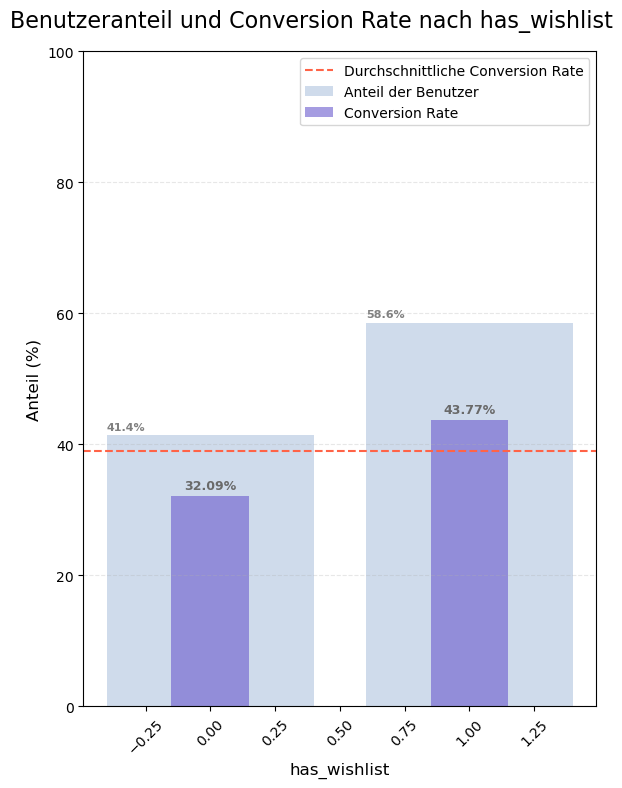

In [55]:
fn.plot_share_vs_conversion(df_active_user, 'has_wishlist', size=(6,8), color_share='lightsteelblue', color_cv='slateblue')

**Empfehlung:** Wenn nach dem Hinzufügen zu einer Wunschliste eine Erinnerung oder ein Anreiz (z.B. Rabatt) gesendet wird, könnte dies die Konversionsrate weiter erhöhen.

## Conversion Funnel

Bei der Buchung einer Reise durchlaufen Nutzer vier Phasen:

- Suche,
- Auswahl von Optionen,
- Absicht (Auswahl von Daten, Hinzufügen von Informationen zu Reisenden),
- eigentliche Buchung.

**Ziel:** Analyse, wie viele Nutzer zur nächsten Phase übergehen. Dies hilft zu verstehen, in welcher Phase die meisten Nutzer verloren gehen und worauf man sich dementsprechend konzentrieren sollte.

In [56]:
# DataFrame für die Schritte im Funnel
actions = pd.DataFrame({ # Definition der Aktionen für jeden Schritt im Funnel
    'search': pd.Series(['search','search_results','ajax_get_results']),
    'view': pd.Series(['listing','view','show']),
    'intent': pd.Series(['ajax_check_dates','add_guests']),
    'booking': pd.Series(['book','booking','reservation','apply_reservation','special_offer','preapproval', 'at_checkpoint']),
    # 'payment': pd.Series(['pay','receipt'])
})

df_funnel = pd.DataFrame({'step': pd.Series(actions.columns)})

for step in actions.columns: # Zähle die eindeutigen Nutzer für jeden Schritt
    num_users_with_step = df_clickstreams[df_clickstreams['session_action'].isin(actions[step])]['session_user_id'].nunique()
    df_funnel.loc[df_funnel['step'] == step, 'num_users'] = num_users_with_step

df_funnel

step  num_users
0   search    79843.0
1     view   110595.0
2   intent    17111.0
3  booking     7152.0

In [57]:
# Visualisierung des Funnels
fig = go.Figure(go.Funnel(
    y=df_funnel["step"],
    x=df_funnel["num_users"],
    textinfo="value+percent initial", # Anzeige von absoluten Werten und Prozentwerten bezogen auf den Anfangswert
    opacity=0.9,
    marker = {"color": ["lightskyblue", "deepskyblue", "slateblue", "navy"],
    "line": {"width": [4, 3, 2, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}},
))
fig.update_yaxes(categoryorder='array', categoryarray=['search', 'view', 'intent', 'booking']) # Reihenfolge der Schritte festlegen
fig.update_layout(title="User funnel (counts + % of initial)")
fig.show()

Der große Anteil der Phase `view` lässt sich dadurch erklären, dass Nutzer Reiseoptionen auch ohne Suchfunktion sehen können, beispielsweise auf der Startseite.

Um einen genaueren Conversion Funnel zu erstellen, zeigen wir nun nur diejenigen Nutzer an, die den vorherigen Schritt durchlaufen haben.

In [58]:
# DataFrame für die Schritte im Funnel (1/0 für jeden Nutzer)
df_steps = pd.DataFrame({'session_user_id': df_clickstreams['session_user_id'].unique()})

for step in actions.columns: # Markiere Nutzer, die jeden Schritt durchlaufen haben
    users_with_step = df_clickstreams[df_clickstreams['session_action'].isin(actions[step])]['session_user_id'].unique()
    df_steps[step] = df_steps['session_user_id'].isin(users_with_step).astype(int)

df_steps.head()

session_user_id  search  view  intent  booking
0      d1mm9tcy42       1     1       0        0
1      yo8nz8bqcq       0     1       0        0
2      4grx6yxeby       0     0       0        0
3      ncf87guaf0       1     1       0        0
4      4rvqpxoh3h       0     0       0        0

In [59]:
# Strenger Funnel: Nur Nutzer, die den vorherigen Schritt durchlaufen haben
strict_counts = []
df_temp = df_steps.copy()

for step in actions.columns: # Zähle nur Nutzer, die alle vorherigen Schritte durchlaufen haben
    count = df_temp[step].sum()
    strict_counts.append(count)
    df_temp = df_temp[df_temp[step] == 1] # Filtert nur Nutzer, die den aktuellen Schritt durchlaufen haben

df_funnel['num_users_strict'] = strict_counts
df_funnel

step  num_users  num_users_strict
0   search    79843.0             79843
1     view   110595.0             77240
2   intent    17111.0             11730
3  booking     7152.0               592

In [60]:
# Visualisierung des strengen Funnels
fig = go.Figure(go.Funnel(
    y=df_funnel["step"],
    x=df_funnel["num_users_strict"],
    textinfo="value+percent initial", # Anzeige von absoluten Werten und Prozentwerten bezogen auf den Anfangswert
    opacity=0.9,
    marker = {"color": ["lightskyblue", "deepskyblue", "slateblue", "navy"],
    "line": {"width": [4, 3, 2, 1], "color": ["wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}
))

fig.update_yaxes(categoryorder='array', categoryarray=['search', 'view', 'intent', 'booking'])
fig.update_layout(title="User funnel (counts + % of initial)")
fig.show()

## 6.Lassen sich im Vergleich zwischen Erstbuchungen aus dem Jahr 2010 und 2011 Unterschiede hinsichtlich des Männer- bzw- Frauenanteils nachweisen? Gilt dasselbe auch zwischen 2014 und 2015?

**Ziel:** Prüfen, ob sich der Männer-/Frauenanteil unter *Erstbuchungen* zwischen 2010–2011 bzw. 2014–2015 unterscheidet.

**Vorgehen:**
1. Nur Nutzer mit Erstbuchung betrachten + Jahr extraktion + fehlende Werte prüfen
3. Chi2-Test auf Unabhängigkeit und Effektgröße (Cramer’s V) 
5. Visualisierung: 100%-Stacked Bars + `n=` Annotation pro Jahr.

### 6.1. Nur Nutzer mit Erstbuchung betrachten + Jahr extraktion + fehlende Werte prüfen

Wir betrachten nur die Nutzer, die eine Reise genucht haben (`first_booking_date` muss nicht NaN sein) und anschließend extrahieren daraus ein Jahr zur weitere Analyse.

In den frühen Jahren ist der Anteil der Einträge außerhalb {male, female} sehr hoch. Würden wir diese Fälle in die Prozentbasis aufnehmen, könnten Unterschiede primär durch Datenqualität/Erfassungslogik entstehen und nicht durch echte Änderungen im Nutzerprofil.

**Hinweis zur Interpretation:** Die folgenden Ergebnisse gelten daher für den Teil der Erstbuchungen mit bekanntem Geschlecht. Die `unknown_gender_rate` verwenden wir als Qualitätsindikator pro Jahr.

**Datenqualität (unknown-rate):**

- 2010 liegt die Unknown-Rate mit rund **52%** sehr hoch, 2011 sinkt sie auf ca. **42%**.
- Auch 2014/2015 ist die Unknown-Rate noch relevant (ca. **35%** bzw. **26%**), aber deutlich niedriger als 2010.

**Interpretation:** Ein Teil der "Jahresunterschiede" kann grundsätzlich aus veränderten Erhebungs-/Profilierungsprozessen stammen. Deshalb sind (a) Filter auf `male/female` und (b) die Angabe von `n` pro Jahr wichtig.

In [61]:
df_temp = df_user[df_user['first_booking_date'].notna()].copy()

# Jahr extrahieren
df_temp['first_booking_year'] = df_temp['first_booking_date'].dt.year.astype('int64')

# Geschlecht: nur Male und Female
known = df_temp['user_gender'].isin(['male', 'female'])
df_known = df_temp[known].copy()

# Fehlende Werte pro Jahr
unknown_rate = (df_temp.groupby('first_booking_year')['user_gender']
                  .apply(lambda s: (~s.isin(['male','female', 'other'])).mean()) # Anteil unbekannter Geschlechter
                  .reset_index(name='unknown_gender_rate'))
unknown_rate

first_booking_year  unknown_gender_rate
0                2010             0.521860
1                2011             0.420000
2                2012             0.229876
3                2013             0.330197
4                2014             0.347721
5                2015             0.261591

### 6.2. Signifikanztest und Effektgröße

Wir testen pro Jahrespaar eine 2x2-Kontingenztabelle (Jahr x Geschlecht) mit dem Chi-Quadrat-Test auf Unabhängigkeit.

**Ergebnisse (bekannte Geschlechter):**
- **2010 vs 2011:** Männeranteil sinkt von **57,4%** auf **51,9%** (**−5,5 Prozentpunkte**). Der Unterschied ist **statistisch signifikant** (p ≈ **0,0098**), die Effektgröße ist jedoch **klein** (Cramer’s V ≈ **0,041**).
- **2014 vs 2015:** Männeranteil steigt von **53,2%** auf **55,5%** (**+2,3 Prozentpunkte**). Der Unterschied ist **nicht signifikant** auf 5%-Niveau (p ≈ **0,1186**) und die Effektgröße ist **sehr klein** (Craeér’s V ≈ **0,0105**).

**Interpretation:**
- 2010-->2011 spricht die Statistik für eine echte Verschiebung der Geschlechterverteilung (im 'known'-Subset), allerdings mit geringer praktischer Effektstärke.
- 2014-->2015 ist die beobachtete Verschiebung klein und kann plausibel durch Zufallsschwankungen erklärt werden (insbesondere, weil 2015 deutlich kleineres `n` hat).

In [62]:
def compare_gender_years(df_known, year_a, year_b):
    """Vergleicht die Geschlechterverteilung zwischen zwei Jahren."""
    sub = df_known[df_known['first_booking_year'].isin([year_a, year_b])].copy()

    tab = pd.crosstab(sub['first_booking_year'], sub['user_gender']).reindex( # Kreuztabelle
        index=[year_a, year_b], columns=['female','male'], fill_value=0
    )

    chi2, p, dof, expected = chi2_contingency(tab.values) # Chi-Quadrat-Test

    # Effektgröße: Cramer's V (für 2x2 entspricht das sqrt(chi2/n))
    n = tab.values.sum()
    if np.isnan(chi2):
        cramers_v = np.nan
    else:
        cramers_v = np.sqrt(chi2 / n)

    # Anteil Männer pro Jahr + Differenz
    n_a = tab.loc[year_a].sum() # Gesamtanzahl Jahr A
    n_b = tab.loc[year_b].sum() # Gesamtanzahl Jahr B
    p_a_male = tab.loc[year_a, 'male'] / n_a if n_a > 0 else np.nan # Anteil Männer Jahr A
    p_b_male = tab.loc[year_b, 'male'] / n_b if n_b > 0 else np.nan # Anteil Männer Jahr B
    p_a_female = tab.loc[year_a, 'female'] / n_a if n_a > 0 else np.nan # Anteil Frauen Jahr A
    p_b_female = tab.loc[year_b, 'female'] / n_b if n_b > 0 else np.nan # Anteil Frauen Jahr B
    diff_male = p_b_male - p_a_male # Differenz Männeranteil
    diff_female = p_b_female - p_a_female # Differenz Frauenanteil

    summary = {
        "years": f"{year_a} vs {year_b}",
        "p_value": p,
        "cramers_v": cramers_v,
        "male_share_year_a": p_a_male,
        "male_share_year_b": p_b_male,
        "female_share_year_a": p_a_female,
        "female_share_year_b": p_b_female,
        "diff_male_share": diff_male,
        "diff_female_share": diff_female,

        "n_year_a": int(n_a),
        "n_year_b": int(n_b),
    }
    return summary

res_2010_2011 = compare_gender_years(df_known, 2010, 2011)
res_2014_2015 = compare_gender_years(df_known, 2014, 2015)

df = pd.DataFrame([res_2010_2011, res_2014_2015])
df

years   p_value  cramers_v  male_share_year_a  male_share_year_b  \
0  2010 vs 2011  0.009831   0.041094           0.574128           0.519178   
1  2014 vs 2015  0.118608   0.010508           0.532425           0.555210   

   female_share_year_a  female_share_year_b  diff_male_share  \
0             0.425872             0.480822        -0.054950   
1             0.467575             0.444790         0.022785   

   diff_female_share  n_year_a  n_year_b  
0           0.054950       688      3259  
1          -0.022785     20771      1286

### 6.3. Visualisierung

In [63]:
def plot_gender_share(df_known, years, title):
    """Plottet die Geschlechteranteile für die angegebenen Jahre."""
    sub = df_known[df_known['first_booking_year'].isin(years)].copy()

    agg = (sub.groupby(['first_booking_year','user_gender'])
             .size().reset_index(name='count'))

    agg['share'] = agg.groupby('first_booking_year')['count'].transform(lambda x: x/x.sum()) # Anteil berechnen

    totals = agg.groupby('first_booking_year')['count'].sum().reset_index(name='n_total') # Gesamtanzahl pro Jahr
    agg = agg.merge(totals, on='first_booking_year', how='left') # Merge der Gesamtanzahl

    fig = px.bar(
        agg, x='share', y='first_booking_year', color='user_gender',
        color_discrete_map={'male': 'steelblue', 'female': 'indianred'},
        opacity=0.85,
        #color_discrete_map={'male': 'cornflowerblue', 'female': 'plum'},
        barmode='stack',
        text=agg['share'].map(lambda v: f"{v:.1%}"),
        title=title,
        orientation='h',
        custom_data = ['count', 'n_total'],
        template='plotly_white'
    )

    fig.update_traces(
        hovertemplate = (
            'Year=%{y}<br>'
            'Gender=%{legendgroup}<br>'
            'Share=%{x:.1%}<br>'
            'Count=%{customdata[0]}<br>'
            'Overall(known)n=%{customdata[1]}<extra></extra>'
        )
    )

    n_labels = totals.copy()
    n_labels['x'] = 1.04
    fig.add_scatter(
        x=n_labels['x'],
        y=n_labels['first_booking_year'],
        mode='text',
        text=n_labels['n_total'].map(lambda n: f"n={n}"),
        showlegend=False
    )
    fig.update_layout(
        xaxis_tickformat=".0%",
        yaxis_title="Jahr (Erstbuchung)",
        xaxis_title="Anteil",
        legend_title_text="Geschlecht",
        width=1000,
        height=400,
    )
    fig.show()

plot_gender_share(df_known, [2010, 2011], "Erstbuchungen: Geschlechteranteile 2010 vs 2011")
plot_gender_share(df_known, [2014, 2015], "Erstbuchungen: Geschlechteranteile 2014 vs 2015")

### Fazit zu Frage 6

- **2010 vs 2011:** Ja, es lassen sich Unterschiede im Männer-/Frauenanteil unter den Erstbuchungen nachweisen. Der Männeranteil sinkt um rund **5,5 Prozentpunkte**; der Chi-Quadrat-Test ist **signifikant** (p < 0,01). Die Effektgröße (Cramer’s V) ist jedoch **klein**, d.h. der Unterschied ist statistisch klar, aber inhaltlich moderat.

- **2014 vs 2015:** Nein, für 2014 vs 2015 finden wir **keinen** statistisch belastbaren Unterschied (p ≈ 0,12). Die beobachtete Veränderung (ca. **+2,3 Prozentpunkte** Männeranteil) ist klein und die Effektgröße sehr gering.

**Wichtiger Qualitätsaspekt:** Die Unknown-Rate ist insbesondere 2010/2011 hoch. Die Analyse ist deshalb bewusst auf `male/female` beschränkt und sollte als Aussage über das 'known'-Subset verstanden werden.

## 7. Sofern es für einen der entdeckten Zusammenhänge Sinn macht, überprüfen Sie, ob er direkt oder indirekt ist, d.h. ob er sich durch andere Merkmale erklären lässt. (Dies bietet sich natürlich vor allem an, wenn Sie drei Merkmale identifiziert haben, die alle miteinander in Zusammenhang stehen, also z.B. A mit B, B mit C und auch A mit C. Wählen Sie im Zweifelsfall natürlich möglichst einen Zusammenhang, bei dem diese Frage auch interessant ist.

**Ziel:** Für einen gefundenen Zusammenhang prüfen, ob er direkt ist oder durch ein drittes Merkmal erklärt wird (indirekt).

**Konkretes Setup (aus Frage 3):**
- A = Gender, B = Alter (age_category), C = Device.

**Vorgehen:**
1. Zeige, dass A–B, B–C und A–C jeweils zusammenhängen.
2. Kontrolle von B:
   - Stratifiziere nach Alterskategorien und prüfe A–C *innerhalb* jeder Kategorie (p + Cramér’s V).

**Entscheidungsregel:**
- *Indirekt*, wenn der A–C-Effekt nach Kontrolle von B stark abnimmt/verschwindet.
- *Direkt (teilweise)*, wenn A–C auch nach Kontrolle von B stabil bleibt.


### 7.1. Einzelne Zusamenhänge prüfen

In [64]:
def chi2(a,b):
    """Chi-Quadrat-Test für Unabhängigkeit zwischen zwei kategorialen Variablen."""
    contingency_table = pd.crosstab(a, b)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.to_numpy().sum() # Gesamtanzahl der Beobachtungen
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1))) # Cramer's V

    print('Chi2-Wert=%.3f' % (chi2))
    print('dof=%.3f' % (dof))
    print('p-value=%.3f' % (p))
    print("Cramer's Value=%.3f" % (cramers_v))
    if p < 0.05:
        print("Es gibt einen signifikanten Zusammenhang ")
    else:
        print("Es gibt keinen signifikanten Zusammenhang ")
    return contingency_table

**Interpretation:**

- p-value = 0.000 --> Es gibt einen statistisch signifikanten Zusammenhang zwischen Geschlecht und erstem Gerät.
- Cramer's V = 0.061 --> Die Effektstärke ist klein (Zusammenhang existiert, aber praktische Relevanz ist begrenzt).

**Interpretation der Kontingenztafel (inhaltlich):**

Aus den Häufigkeiten (in Anteilen pro Geschlecht gedacht) ergeben sich kleine, aber systematische Unterschiede:
- Männer haben relativ häufiger Mac Desktop (ca. +2,25 Prozentpunkte gegenüber Frauen).
- Männer haben relativ häufiger iPad (ca. +1,92 Prozentpunkte).
- Frauen haben relativ häufiger Windows Desktop (ca. +1,93 Prozentpunkte).
- Frauen haben relativ häufiger iPhone (ca. +0,73 Prozentpunkte).

**Zwischenfazit (A --> C):**

Geschlecht hängt mit der Geräteverteilung zusammen, aber der Unterschied ist nicht groß (kleines Cramer’s V). Bei sehr großen Stichproben führen schon kleine Unterschiede zu sehr kleinen p-Werten.


In [65]:
df = df_user[df_user['user_gender'].isin(['male','female'])].copy()

# 1. A --> C (Gender und Gerät)
chi2(df['user_gender'], df['first_device'])

Chi2-Wert=427.090
dof=8.000
p-value=0.000
Cramer's Value=0.061
Es gibt einen signifikanten Zusammenhang 


first_device  Android Phone  Android Tablet  Desktop (Other)  Mac Desktop  \
user_gender                                                                 
female                  653             243              422        24063   
male                    619             325              253        29178   

first_device  Other/Unknown  SmartPhone (Other)  Windows Desktop  iPad  iPhone  
user_gender                                                                     
female                 2097                  16            18598  2746    4761  
male                   1800                  28            20283  4361    5048

**Interpretation:**

- p-value = 0.000 --> Geschlecht und Alterskategorie sind signifikant assoziiert.
- Cramer's V = 0.069 --> Effekt klein, aber vorhanden.

**Inhaltliche Interpretation der Tabelle:**

- Männer sind anteilig etwas stärker in den Kategorien 15–24 und 25–34 vertreten.
- Frauen sind anteilig etwas stärker in 35–44 und 45–54 vertreten.

**Zwischenfazit (A --> B):**

Alter ist ein potenzieller Erklärungsfaktor, da es mit dem Geschlecht zusammenhängt.

In [66]:
# 2. A -> B (Gender und Alter)
chi2(df['user_gender'], df['user_age_category'])

Chi2-Wert=501.122
dof=5.000
p-value=0.000
Cramer's Value=0.069
Es gibt einen signifikanten Zusammenhang 


user_age_category  15-24  25-34  35-44  45-54  55-64   65+
user_gender                                               
female              3542  22490  13513   6175   2742  1375
male                5564  26298  13068   6302   3739  1597

**Interpretation:**

- p-value = 0.000 --> Alter und erstes Gerät sind signifikant assoziiert.
- Cramer's V = 0.064 --> Effekt klein, aber robust.

**Zwischenfazit (B --> C):**

Alter beeinflusst die Geräteverteilung (erwartbar), daher kann Alter den Zusammenhang zwischen Geschlecht und Gerät teilweise mit erklären.

In [67]:
# 3. B -> C (Alter und Gerät)
chi2(df['user_age_category'], df['first_device'])

Chi2-Wert=2152.816
dof=40.000
p-value=0.000
Cramer's Value=0.064
Es gibt einen signifikanten Zusammenhang 


first_device       Android Phone  Android Tablet  Desktop (Other)  \
user_age_category                                                   
15-24                        117              35               58   
25-34                        532             205              326   
35-44                        256             136              156   
45-54                         97              62               58   
55-64                         39              54               20   
65+                           10              27               14   

first_device       Mac Desktop  Other/Unknown  SmartPhone (Other)  \
user_age_category                                                   
15-24                     4441            322                   3   
25-34                    23186           1595                  16   
35-44                    12780            933                  10   
45-54                     5528            351                   3   
55-64                     2554            180                   3   
65+                       1102             94                   1   

first_device       Windows Desktop  iPad  iPhone  
user_age_category                                 
15-24                         2650   358    1122  
25-34                        15756  2334    4838  
35-44                         8382  1801    2127  
45-54                         4617  1111     650  
55-64                         2803   635     193  
65+                           1380   272      72

Für fast alle Altersgruppen (15–24 bis 55–64) gilt: p_value = 0.000 und Cramer's V liegt etwa zwischen 0.055 und 0.090.
Für 65+: p_value = 0.144 --> kein signifikanter Zusammenhang (gleichzeitig ist n hier am kleinsten: 2972).

**Interpretation:**

Der Zusammenhang Geschlecht–Gerät verschwindet nicht, wenn wir nach Alter "kontrollieren", indem wir getrennt innerhalb der Altersgruppen testen.
Die Gruppe 65+ ist eine Ausnahme; das kann bedeuten:
- der Effekt ist in 65+ tatsächlich schwächer/abwesend, und/oder
- die Aussagekraft ist geringer (kleineres n, ggf. seltene Gerätekategorien).

**Zwischenfazit:**

Alter erklärt den Zusammenhang nicht vollständig. Es bleibt ein (kleiner) geschlechtsspezifischer Unterschied innerhalb der meisten Altersgruppen.

### 6.2. Bleibt der Zusammenhang Geschlecht–Gerät innerhalb von Altersgruppen bestehen?

In [68]:
def cramers_v_from_table(tab):
    """Berechnet p-Wert, Cramer's V und Anteil erwarteter Werte < 5 aus einer Kontingenztabelle."""
    chi2, p, dof, expected = chi2_contingency(tab)
    n = tab.to_numpy().sum()
    k = min(tab.shape)
    V = np.sqrt(chi2 / (n * (k - 1))) if k > 1 else np.nan
    share_exp_lt5 = (expected < 5).sum() / expected.size
    return p, V, share_exp_lt5

rows = []
for b in df['user_age_category'].dropna().unique(): # Für jede Alterskategorie
    sub = df[df['user_age_category'] == b] # Subset für die Alterskategorie
    tab = pd.crosstab(sub['user_gender'], sub['first_device']) # Kreuztabelle Geschlecht vs Gerät
    if tab.shape[0] == 2 and tab.shape[1] >= 2:
        p, V, bad = cramers_v_from_table(tab)
        rows.append([str(b), len(sub), p.round(3), V.round(3)]) # Ergebnis speichern

res = pd.DataFrame(rows, columns=['age_category','n','p_value','cramers_v'])
res.sort_values('n', ascending=False)

age_category      n  p_value  cramers_v
2        25-34  48788    0.000      0.067
0        35-44  26581    0.000      0.065
1        45-54  12477    0.000      0.055
5        15-24   9106    0.000      0.090
3        55-64   6481    0.000      0.069
4          65+   2972    0.144      0.064

### Fazit zu Frage 7

Die Analyse zeigt einen **statistisch signifikanten Zusammenhang** zwischen Geschlecht und dem ersten Gerät, der **teilweise indirekt über das Alter** erklärt werden kann. Gleichzeitig bleibt auch nach Kontrolle des Alters ein **direkter (bzw. altersunabhängiger) Effekt** des Geschlechts bestehen. Insgesamt sind die Effekte jedoch klein, d. h. es handelt sich eher um moderate Verschiebungen in Anteilen/Wahrscheinlichkeiten als um starke Unterschiede.